# Please install jupyter nbextensions (https://jupyter-contrib-nbextensions.readthedocs.io/en/latest/install.html) and enable collapsable headers (othrerwise this notebook becomes an impossible maze of misery)

In [1]:
#!pip install jupyter_contrib_nbextensions

In [2]:
#!jupyter contrib nbextension install --user

In [3]:
#!jupyter nbextension enable collapsible_headings/main

In [4]:
#!pip install seaborn

In [6]:
!pip install astropy

Failed to import the site module
ModuleNotFoundError: No module named 'site'


In [8]:
!pip install site

Failed to import the site module
ModuleNotFoundError: No module named 'site'


# Import packages

In [23]:
# #Miles' packages
# from astropy.table import Table
# import astropy.coordinates as coord
import glob
# from astropy import units as u

#data processing
import pandas as pd
import numpy as np
import math as math
from tqdm import tqdm
import collections
import copy

#visualizations
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.use('Agg')
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
# import plotly.graph_objects as go
# import seaborn as sns

#models
from sklearn.cluster import DBSCAN
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import OneClassSVM
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import RandomizedSearchCV

#data manipulation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import matthews_corrcoef

#for my sanity
import warnings
warnings.filterwarnings('ignore')

In [13]:
from astroquery.gaia import Gaia

ImportError: No module named 'astroquery'

# Import simulated stream data

In [ ]:
stream_data_base = 'gaia_mock_streams/'
stream_files = glob.glob(stream_data_base + 'stream*.fits.gz')

We now have all the stream files:

In [ ]:
print(len(stream_files))
stream_files[:5]

In [ ]:
# analysis_stream_data_base = 'noise_points/'
# analysis_stream_files = glob.glob(analysis_stream_data_base + 'stream*.csv')
# len(analysis_stream_files)

# analysis_stream_files = [i[13:] for i in analysis_stream_files]
# analysis_stream_files = [i.split("_")[0] for i in analysis_stream_files]

# len_streams = []

# for i in analysis_stream_files:
#     new_string = 'gaia_mock_streams/' + i + '.fits.gz'
#     table = Table.read(new_string, format='fits')
#     stream = table.to_pandas()
#     len_streams.append(len(stream))

In [ ]:
# stream_info = np.column_stack((analysis_stream_files, len_streams))
# stream_info = pd.DataFrame(stream_info, columns = ['stream_name', 'stream_length'])
# stream_info.stream_length = stream_info.stream_length.astype(int)

# obtain_model_streams = ['178','9528', '1954', '2408', '4682', '5402', '3526', '9164', '2985']
# obtain_model_streams = ['stream-'+i for i in obtain_model_streams]
# stream_info_obtain_kNN = stream_info[stream_info.stream_name.isin(obtain_model_streams)]
# stream_info_not_obtain_kNN = stream_info[~stream_info.stream_name.isin(obtain_model_streams)]

In [ ]:
# #how many have number of stars > 100
# suff_length = stream_info_not_obtain_kNN[stream_info_not_obtain_kNN.stream_length > 100]
# print(len(suff_length))

# group_b_streams, group_c_streams = train_test_split(suff_length, test_size=0.75, random_state = 1)
# print(len(group_b_streams), len(group_c_streams))

# group_b_streams

In [ ]:
#group_b_streams.stream_name

In [14]:
#relevant cut for each stream
cuts = pd.read_csv("cuts/cuts3.csv")

In [15]:
cuts.head()

,stream_file,ra_min,ra_max,dec_min,dec_max
0,gaia_mock_streams/stream-6739.fits.gz,5.006626,353.706544,-72.726224,62.999930
1,gaia_mock_streams/stream-4624.fits.gz,3.415784,342.776381,-81.250596,88.556886
2,gaia_mock_streams/stream-5698.fits.gz,7.388297,359.337578,-83.504925,82.960142
3,gaia_mock_streams/stream-2985.fits.gz,152.502007,315.609415,-75.067902,81.916498
4,gaia_mock_streams/stream-847.fits.gz,0.225259,359.991680,-41.113838,78.557753


## let us write a function to extract the Gaia noise points based on some inputs

In [16]:
def obtain_noise(min_ra, max_ra, min_dec, max_dec, max_rel_err, n_points):
    
    qry = f" \n\
    select top {n_points} source_id, \n\
    dr2.ra, \n\
    dr2.dec, \n\
    parallax, \n\
    parallax_error, \n\
    pmra, \n\
    pmdec, \n\
    phot_g_mean_mag,\n\
    phot_bp_mean_mag, \n\
    phot_rp_mean_mag, \n\
    bp_rp, \n\
    bp_g, \n\
    g_rp\n\
    from gaiadr2.gaia_source as dr2 \n\
    where dr2.ra > {min_ra} and dr2.ra < {max_ra} and dr2.dec > {min_dec} and dr2.dec < {max_dec} \n\
    and parallax is not null \n\
    and parallax_error is not null \n\
    and abs(dr2.parallax/dr2.parallax_error) < {max_rel_err} \n\
    and pmra is not null \n\
    and pmdec is not null \n\
    and phot_g_mean_mag is not null \n\
    and phot_bp_mean_mag is not null \n\
    and phot_rp_mean_mag is not null \n\
    and bp_rp is not null \n\
    and bp_g is not null \n\
    and g_rp is not null \n\
    order by random_index"

    data_noise = Gaia.launch_job_async(qry).get_results().to_pandas()
    
    return data_noise

SyntaxError: invalid syntax (<ipython-input-16-bc5756f0a343>, line 3)

# Let us define our models here

In [54]:
#let us define a function to run logistic regression on our data set and evaluate the results
def log_reg_model(X_train, X_test, y_train, y_test, threshold_log):
    #do the logistic regression modeling
    log_reg = LogisticRegression(random_state=0, solver='lbfgs', max_iter=1000, multi_class='ovr').fit(X_train, y_train)
    
    THRESHOLD = threshold_log
    y_pred = np.where(log_reg.predict_proba(X_test)[:,1] > THRESHOLD, 1, 0)
    
    y_pred = log_reg.predict(X_test)
    y_true = np.array(y_test)
    
    #calculate metrics
    precision = metrics.precision_score(y_true, y_pred)
    recall = metrics.recall_score(y_true, y_pred)
    accuracy = metrics.accuracy_score(y_true, y_pred)

    #calculate the AUC
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
    auc = metrics.auc(fpr, tpr)
    
    return precision, recall, accuracy, auc, y_pred, y_true

#defaults for hyperparameters are set to match those used in sklearn
def random_forest_model(X_train, X_test, y_train, y_test, n_trees = 100, criterion = "gini", max_depth = None,
                       min_samples_split = 2, min_samples_leaf = 1, min_weight_fraction_leaf = 0, max_features = "auto", 
                        max_leaf_nodes = None, min_impurity_split = 1e-7, bootstrap = True,
                        oob_score = False, n_jobs = None, random_state = None, verbose = 0, warm_start = False, class_weight = {0:1,1:1}):
    #do the random forest modeling
    random_forest = RandomForestClassifier(
                                            n_estimators = n_trees, criterion = criterion, 
                                            max_depth = max_depth, min_samples_split = min_samples_split, 
                                            min_samples_leaf = min_samples_leaf, 
                                            min_weight_fraction_leaf = min_weight_fraction_leaf, 
                                            max_features = max_features, max_leaf_nodes = max_leaf_nodes,  
                                            min_impurity_split = min_impurity_split, bootstrap = bootstrap, 
                                            oob_score = oob_score, n_jobs = n_jobs, 
                                            random_state = random_state, verbose = verbose, warm_start = False,
                                            class_weight = {0:weight_0,1:weight_1}
                                          ).fit(X_train, y_train)
    
    y_pred = random_forest.predict(X_test)
    y_true = np.array(y_test)
    
    #calculate metrics
    precision = metrics.precision_score(y_true, y_pred)
    recall = metrics.recall_score(y_true, y_pred)
    accuracy = metrics.accuracy_score(y_true, y_pred)

    #calculate the AUC
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
    auc = metrics.auc(fpr, tpr)
    
    return precision, recall, accuracy, auc, y_pred, y_true, random_forest

#defaults for hyperparameters are set to match those used in sklearn
def gradient_boost_model(X_train, X_test, y_train, y_test, loss = 'deviance', learning_rate = 0.1, n_estimators = 100, 
                         subsample = 1.0, criterion = "friedman_mse", min_samples_split = 2, 
                         min_samples_leaf = 1, min_weight_fraction_leaf = 0., max_depth = 3, 
                         min_impurity_decrease = 0, min_impurity_split = 1e-7, init = None,
                         random_state = None, max_features = None, max_leaf_nodes = None, verbose = 0,
                         warm_start  = False): #validation_fraction = 0.1, 
                         #n_iter_no_change = None, tol = 1e-4, ccp_alpha = 0.0):
    #do the gradient boosting modeling
    gradient_boost = GradientBoostingClassifier(
                                                loss = loss, learning_rate = learning_rate, 
                                                n_estimators = n_estimators, 
                                                subsample = subsample, criterion = criterion, 
                                                min_samples_split = min_samples_split, 
                                                min_samples_leaf = min_samples_leaf, 
                                                min_weight_fraction_leaf = min_weight_fraction_leaf, 
                                                max_depth = max_depth, 
                                                min_impurity_decrease = min_impurity_decrease, 
                                                min_impurity_split = min_impurity_split, init = init,
                                                random_state = random_state, max_features = max_features, 
                                                max_leaf_nodes = max_leaf_nodes, verbose = verbose,
                                                warm_start = warm_start #validation_fraction = validation_fraction, 
                                                #n_iter_no_change = n_iter_no_change, tol = tol, ccp_alpha = ccp_alpha
                                              ).fit(X_train, y_train)
    
    y_pred = gradient_boost.predict(X_test)
    y_true = np.array(y_test)
    
    #calculate metrics
    precision = metrics.precision_score(y_true, y_pred)
    recall = metrics.recall_score(y_true, y_pred)
    accuracy = metrics.accuracy_score(y_true, y_pred)

    #calculate the AUC
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
    auc = metrics.auc(fpr, tpr)
    
    return precision, recall, accuracy, auc, y_pred, y_true

#defaults for hyperparameters are set to match those used in sklearn
def one_class_svm_model(X_train, X_test, y_train, y_test, 
                        kernel = 'rbf', degree = 3, gamma = 0.001, 
                        coef0 = 0.0, tol = 0.001, nu = 0.5, shrinking = True, 
                        cache_size = 200, verbose = False, max_iter = -1, random_state = None):
    #do the random forest modeling
    one_class_svm = OneClassSVM(
                                kernel = kernel, degree = degree, gamma = gamma, coef0 = coef0, 
                                tol = tol, nu = nu, shrinking = shrinking, cache_size = cache_size, 
                                verbose = verbose, max_iter = max_iter, random_state = random_state
                               ).fit(X_train, y_train)
    
    y_pred = one_class_svm.predict(X_test)
    y_true = np.array(y_test)
    
    #calculate metrics
    precision = metrics.precision_score(y_true, y_pred, average='micro')
    recall = metrics.recall_score(y_true, y_pred, average='micro')
    accuracy = metrics.accuracy_score(y_true, y_pred)

    #calculate the AUC
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
    auc = metrics.auc(fpr, tpr)
    
    return precision, recall, accuracy, auc, y_pred, y_true

def knn_model(X_train, X_test, y_train, y_test, k):
    #do the KNN modeling
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(X_train, y_train)
    y_pred = neigh.predict(X_test)
    y_true = np.array(y_test)
    
    #calculate metrics
    precision = metrics.precision_score(y_true, y_pred)
    recall = metrics.recall_score(y_true, y_pred)
    accuracy = metrics.accuracy_score(y_true, y_pred)

    #calculate the AUC
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
    auc = metrics.auc(fpr, tpr)
    
    return precision, recall, accuracy, auc, y_pred, y_true

## For each mock stream, we wish to obtain a fixed test set that represents the realistic ratio of non-stream stars to stream stars that we expect after applying an isochrone filter.
1. This ratio was previously determined to be ~400

In [20]:
def obtain_test_set(list_of_stellar_streams, multiple):

    for i in list_of_stellar_streams:
        table = Table.read(i, format='fits')
        stream = table.to_pandas()
        
        idx = cuts.index[cuts.stream_file==str(i)][0]

        ra_min = cuts.loc[idx].ra_min
        ra_max = cuts.loc[idx].ra_max
        dec_min = cuts.loc[idx].dec_min
        dec_max = cuts.loc[idx].dec_max
        
        #restrict stream to relevant portion
        stream = stream.query('ra > ' + str(ra_min) + ' & ra < ' + str(ra_max) + ' & dec > ' + str(dec_min) + ' & dec < ' + str(dec_max))

        #obtain noise points such that:
        #- the ratio of stream to noise points in the test set is 1:multiple
        #- this is required because KNN introduces bias when the ratios are imbalanced
        n_points = len(stream) * multiple
        #use max_rel_err of 0.5
        max_rel_err =  0.5

        #we now select our noise points that we will incorporate into our training and test set
        noise_points = obtain_noise(ra_min, ra_max, dec_min, dec_max, max_rel_err, n_points)

        #label our data as "not part of the stream"
        noise_points['stream_mask'] = False
        
        #send to csv
        name = i[18:-8]+'_mul_400_total_noise.csv'
        noise_points.to_csv(name)

    return noise_points

In [ ]:
# viable_streams = []

# for i in cuts.stream_file:
#     table = Table.read(i, format='fits')
#     stream = table.to_pandas()
    
#     idx = cuts.index[cuts.stream_file==str(i)][0]

#     ra_min = cuts.loc[idx].ra_min
#     ra_max = cuts.loc[idx].ra_max
#     dec_min = cuts.loc[idx].dec_min
#     dec_max = cuts.loc[idx].dec_max

#     #restrict stream to relevant portion
#     stream2 = stream.query('ra > ' + str(ra_min) + ' & ra < ' + str(ra_max) + ' & dec > ' + str(dec_min) + ' & dec < ' + str(dec_max))
    
#     if len(stream2) < 500 and len(stream2) > 25:
#         viable_streams.append(i)

# len(viable_streams)
# viable_streams

####ONLY NEED TO RUN THIS ONCE
# test2 = obtain_test_set(viable_streams,400)

In [24]:
group_b = 'stream_stars_split/group_b/'
group_b_known = glob.glob(group_b + 'known_to_model/' + '*.csv')
group_b_unknown = glob.glob(group_b + 'unknown_to_model/' + '*.csv')

group_c = 'stream_stars_split/group_c/'
group_c_known = glob.glob(group_c + 'known_to_model/' + '*.csv')
group_c_unknown = glob.glob(group_c + 'unknown_to_model/' + '*.csv')

In [25]:
len(group_b_known), len(group_b_unknown), len(group_c_known), len(group_c_unknown)

(9, 9, 9, 9)

In [26]:
lengths_b_known = []
lengths_b_unknown = []
lengths_c_known = []
lengths_c_unknown = []

for i in group_b_known:
    stars = pd.read_csv(i)
    lengths_b_known.append(len(stars))
    
for i in group_b_unknown:
    stars = pd.read_csv(i)
    lengths_b_unknown.append(len(stars))
    
for i in group_c_known:
    stars = pd.read_csv(i)
    lengths_c_known.append(len(stars))
    
for i in group_c_unknown:
    stars = pd.read_csv(i)
    lengths_c_unknown.append(len(stars))

In [27]:
noise_primer = 'stream_stars_split/simulated_noise_points/150_to_1_ratio/'
noise_points = glob.glob(noise_primer + '*.csv')
noise_points_refined = [i[57:] for i in noise_points]

In [28]:
noise_length = []
for i in noise_points:
    noise = pd.read_csv(i)
    noise_length.append(len(noise))

In [30]:
#b_known: 1012,167,1698,178,3775,532,5406,5489,8137
#c_known: 1101,1519,247,2805,4717,4807,5402,5713,9528 with 5402 previously as first

lengths_b_known, lengths_c_known

([28, 89, 79, 163, 70, 56, 67, 4, 313], [30, 70, 89, 59, 57, 93, 118, 20, 178])

In [31]:
group_b_known, group_c_known

(['stream_stars_split/group_b/known_to_model/group_b_stream-3775_known_to_model.csv',
  'stream_stars_split/group_b/known_to_model/group_b_stream-5489_known_to_model.csv',
  'stream_stars_split/group_b/known_to_model/group_b_stream-8137_known_to_model.csv',
  'stream_stars_split/group_b/known_to_model/group_b_stream-5406_known_to_model.csv',
  'stream_stars_split/group_b/known_to_model/group_b_stream-1698_known_to_model.csv',
  'stream_stars_split/group_b/known_to_model/group_b_stream-1667_known_to_model.csv',
  'stream_stars_split/group_b/known_to_model/group_b_stream-1012_known_to_model.csv',
  'stream_stars_split/group_b/known_to_model/group_b_stream-532_known_to_model.csv',
  'stream_stars_split/group_b/known_to_model/group_b_stream-178_known_to_model.csv'],
 ['stream_stars_split/group_c/known_to_model/group_c_stream-9528_known_to_model.csv',
  'stream_stars_split/group_c/known_to_model/group_c_stream-2805_known_to_model.csv',
  'stream_stars_split/group_c/known_to_model/group_c_st

In [ ]:
#noise_points

In [ ]:
#noise_length

# Train a KNN model

In [33]:
def knn_simulated_stream(stream_name, k_optimal, multiple, train_ratio):

#     table = Table.read(stream_name, format='fits')
#     stream = table.to_pandas()
    
#     idx = cuts.index[cuts.stream_file==stream_name][0]

#     ra_min = cuts.loc[idx].ra_min
#     ra_max = cuts.loc[idx].ra_max
#     dec_min = cuts.loc[idx].dec_min
#     dec_max = cuts.loc[idx].dec_max

#     #restrict stream to relevant portion
#     stream = stream.query('ra > ' + str(ra_min) + ' & ra < ' + str(ra_max) + ' & dec > ' + str(dec_min) + ' & dec < ' + str(dec_max))

#     #label our data as "part of the stream"
#     stream['stream_mask'] = True

#     #split data into training and training data set
#     msk = np.random.rand(len(stream)) < train_ratio
#     stream_train = stream[msk]
#     stream_test = stream[~msk]
    
    stream_primer1 = 'stream_stars_split/train_known/' + stream_name + "_known_to_model.csv"
    stream_primer2 = 'stream_stars_split/test_unknown/' + stream_name + "_unknown_to_model.csv"
    
    #stars known to model
    stream_train = pd.read_csv(stream_primer1, index_col = 0)
    #unknown to model
    stream_test = pd.read_csv(stream_primer2, index_col = 0)


    #obtain noise points such that:
    #- the ratio of stream to noise points in the training set is 1:multiple
    #- the ratio of stream to noise points in the test set is close to the 'real' ratio
    test_primer = 'stream_stars_split/simulated_noise_points/150_to_1_ratio/'
    name_test = test_primer + stream_name[18:-8] + "_mul_150_total_noise.csv"
    
    train_primer = 'stream_stars_split/simulated_noise_points/400_to_1_ratio/'
    name_train = train_primer + stream_name[18:-8] + "_mul_400_total_noise.csv"
    
    noise_test = pd.read_csv(name_test, index_col = 0)
    noise_points = pd.read_csv(name_train, index_col = 0)
    
    #add back the test points into the muck and assume they're background stars from which to draw
    noise_points = noise_points.append(stream_test, ignore_index = False, sort = True)
    train_points = len(stream_train) * multiple

    msk2 = np.random.rand(len(noise_points)) < (train_points / len(noise_points))
    noise_train = noise_points[msk2]
    #noise_test = noise_points[~msk2]
    
    #label our data as "not part of the stream"
    noise_points['stream_mask'] = False

    #combine my stream and noise to obtain complete training and test data set
    training_data = stream_train.append(noise_train, ignore_index = False, sort = True)
    training_data = training_data[['ra', 'dec', 'pmra', 'pmdec', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag', 'stream_mask']]

    testing_data = stream_test.append(noise_test, ignore_index = False, sort = True)
    testing_data = testing_data[['ra', 'dec', 'pmra', 'pmdec',  'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag', 'stream_mask']]

    #differentiate training and test data's X and y variables
    X_train = training_data[['ra', 'dec', 'pmra', 'pmdec', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag']]
    y_train = training_data.stream_mask

    X_test = testing_data[['ra', 'dec', 'pmra', 'pmdec', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag']]
    y_test = testing_data.stream_mask

    #scale the features using standard scaler (scaling not required for logistic regression)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit(X_train).transform(X_train)
    X_test_scaled = scaler.fit(X_test).transform(X_test)

    precision, recall, accuracy, auc, y_pred, y_true = knn_model(X_train_scaled, X_test_scaled, y_train, y_test, k_optimal)
        
    return precision, recall, accuracy, auc, y_pred, y_true


## we try a combination of hyperparameters and record their vote

In [ ]:
# res1 = pd.read_csv('extended_modeling_fixed_ratios_a.csv', index_col = 0)
# res2 = pd.read_csv('extended_modeling_fixed_ratios_b.csv', index_col = 0)
# res3 = pd.read_csv('extended_modeling_fixed_ratios_c.csv', index_col = 0)
# res4 = pd.read_csv('extended_modeling_fixed_ratios_d.csv', index_col = 0)
# res5 = pd.read_csv('extended_modeling_fixed_ratios_e.csv', index_col = 0)
# res6 = pd.read_csv('extended_modeling_fixed_ratios_f.csv', index_col = 0)
# res_12 = res1.append(res2, ignore_index = True)
# res_123 = res_12.append(res3, ignore_index = True)
# res_1234 = res_123.append(res4, ignore_index = True)
# res_12345 = res_1234.append(res5, ignore_index = True)
# res = res_12345.append(res6, ignore_index = True)

# #β is chosen such that recall is considered β times as important as precision
# #try beta = 1
# res['f1_bal']= 2*(res.precision * res.recall)/(res.precision + res.recall)
# #try beta = 0.1
# beta = 0.1
# res['f1_prec_favor'] = (1 + beta**2) * (res.precision * res.recall) / (beta**2 * res.precision + res.recall)
# #try beta = 10
# beta = 10
# res['f1_rec_favor'] = (1 + beta**2) * (res.precision * res.recall) / (beta**2 * res.precision + res.recall)

# res3 = res.groupby(['k','multiple','training_ratio']).mean().sort_values(by = 'f1_bal',ascending = False)
# res3 = res3.reset_index()[['k','multiple','training_ratio']]
# tuples_try = [(list(res3.k)[i], list(res3.multiple)[i], list(res3.training_ratio)[i]) for i in range(len(res3))]

In [ ]:
#len(res.stream_name.unique())

In [ ]:
#restrict models only to models that train on 10% of stellar stream stars i.e. exclude models that use 20% of stars in stream
#not relevant anymore since we're only considering 10% training
# tuples_try_10 = [i for i in tuples_try if i[2] == 0.1]
# len(res3), len(tuples_try), len(tuples_try_10)

In [ ]:
#we know from the "Results" notebook that the top 75 models have a F1_balanced score > 0.5
# tuples_try_10[:10]

In [34]:
valid_eval_stars = group_b_known + group_c_known
valid_eval_stars = [i[50:-19] for i in valid_eval_stars]
#exceptions_temp = [9,10]
viable_new = valid_eval_stars[:9]+valid_eval_stars[9:]

In [35]:
#stream_train.columns, stream_test.columns, noise_points.stream_mask.describe()
viable_new

['stream-3775',
 'stream-5489',
 'stream-8137',
 'stream-5406',
 'stream-1698',
 'stream-1667',
 'stream-1012',
 'stream-532',
 'stream-178',
 'stream-9528',
 'stream-2805',
 'stream-247',
 'stream-4717',
 'stream-5402',
 'stream-5713',
 'stream-1519',
 'stream-4807',
 'stream-1101']

In [31]:
results = {}


for stream_name in tqdm(viable_new):
    
    stream_primer1 = 'stream_stars_split/train_known/' + stream_name + "_known_to_model.csv"
    stream_primer2 = 'stream_stars_split/test_unknown/' + stream_name + "_unknown_to_model.csv"

    #stars known to model
    stream_train = pd.read_csv(stream_primer1, index_col = 0)
    stream_train['stream_mask'] = True
    #unknown to model
    stream_test = pd.read_csv(stream_primer2, index_col = 0)
    stream_test['stream_mask'] = True
    
    votes = []
    
    number_of_votes = 75 #75
    for voter in tuples_try_10[:number_of_votes]:

        k_optimal = voter[0]
        multiple = voter[1]
        training_ratio = voter[2]  

        #obtain noise points such that:
        #- the ratio of stream to noise points in the training set is 1:multiple
        #- the ratio of stream to noise points in the test set is close to the 'real' ratio
        test_primer = 'stream_stars_split/simulated_noise_points/150_to_1_ratio/'
        name_test = test_primer + stream_name + "_mul_150_total_noise.csv"

        train_primer = 'stream_stars_split/simulated_noise_points/400_to_1_ratio/'
        name_train = train_primer + stream_name + "_mul_400_total_noise.csv"

        noise_test = pd.read_csv(name_test, index_col = 0)
        noise_points = pd.read_csv(name_train, index_col = 0)

        #add back the test points into the muck and assume they're background stars from which to draw
        noise_points = noise_points.append(stream_test, ignore_index = False, sort = True)
        train_points = len(stream_train) * multiple

        #label our data as "not part of the stream"
        noise_points['stream_mask'] = False
        
        msk2 = np.random.rand(len(noise_points)) < (train_points / len(noise_points))
        noise_train = noise_points[msk2]
        #noise_test = noise_points[~msk2]

  

        #combine my stream and noise to obtain complete training and test data set
        training_data = stream_train.append(noise_train, ignore_index = False, sort = True)
        training_data = training_data[['ra', 'dec', 'pmra', 'pmdec', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag', 'stream_mask']]
        
        testing_data = stream_test.append(noise_test, ignore_index = False, sort = True)
        testing_data = testing_data[['ra', 'dec', 'pmra', 'pmdec',  'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag', 'stream_mask']]
        
        #Convert to Angular Coordinates
        #ang_coord_1 = -pmdec * cos(ra) - pmra * cos(dec) * sin(dec) * sin(ra)
        #ang_coord_2 = -pmra * cos(dec) * cos(ra) * sin(dec) + pmdec * sin(ra)
        #ang_coord_3 =  pmra ( cos(dec) * cos(dec) )

        deg2rad = lambda deg: deg/180.*np.pi

        #Convert data to angular velocities
        training_data['ra_rad'] = deg2rad(training_data['ra'])
        training_data['dec_rad'] = deg2rad(training_data['dec'])

        training_data['ang_coord_1'] = -1 * training_data.pmdec * ( np.cos(training_data.ra_rad)) -  training_data.pmdec * np.cos(training_data.dec_rad) * np.sin(training_data.dec_rad * np.sin(training_data.ra_rad))
        training_data['ang_coord_2'] = -1 * training_data.pmra *    np.cos(training_data.dec_rad) * np.cos(training_data.ra_rad) * np.sin(training_data.dec_rad + training_data.pmra * np.sin(training_data.ra_rad))
        training_data['ang_coord_3'] = training_data.pmra * ( np.cos(training_data.dec_rad) * np.cos(training_data.dec_rad) )

        testing_data['ra_rad'] = deg2rad(testing_data['ra'])
        testing_data['dec_rad'] = deg2rad(testing_data['dec'])

        testing_data['ang_coord_1'] = -1 * testing_data.pmdec * ( np.cos(testing_data.ra_rad)) -  testing_data.pmdec * np.cos(testing_data.dec_rad) * np.sin(testing_data.dec_rad * np.sin(testing_data.ra_rad))
        testing_data['ang_coord_2'] = -1 * testing_data.pmra *    np.cos(testing_data.dec_rad) * np.cos(testing_data.ra_rad) * np.sin(testing_data.dec_rad + testing_data.pmra * np.sin(testing_data.ra_rad))
        testing_data['ang_coord_3'] = testing_data.pmra * ( np.cos(testing_data.dec_rad) * np.cos(testing_data.dec_rad) )
        

        #differentiate training and test data's X and y variables
        #X_train = training_data[['x', 'y', 'z', 'vx', 'vy', 'vz']] #[['ra', 'dec', 'pmra', 'pmdec']]
        #y_train = training_data.stream_mask

        #X_test = testing_data[['x', 'y', 'z', 'vx', 'vy', 'vz']] #[['ra', 'dec', 'pmra', 'pmdec']]
        #y_test = testing_data.stream_mask
    
                
        #differentiate training and test data's X and y variables
        X_train = training_data[['ra', 'dec', 'pmra', 'pmdec','ang_coord_1', 'ang_coord_2', 'ang_coord_3', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag']]
        y_train = training_data.stream_mask

        X_test = testing_data[['ra', 'dec', 'pmra', 'pmdec','ang_coord_1', 'ang_coord_2', 'ang_coord_3', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag']]
        y_test = testing_data.stream_mask
        
        
        #scale the features using standard scaler (scaling not required for logistic regression)
        scaler = StandardScaler()
        X_train_scaled = scaler.fit(X_train).transform(X_train)
        X_test_scaled = scaler.fit(X_test).transform(X_test)

        precision, recall, accuracy, auc, y_pred, y_true = knn_model(X_train_scaled, X_test_scaled, y_train, y_test, k_optimal)
        votes.append(y_pred)
        
    for i in range(len(votes)):
        name_of_vote = 'voter_' + str(i)
        testing_data[name_of_vote] = votes[i]
    
        #trouble_shooting
        #print(len(y_pred), len(stream_train), len(noise_points), train_points, len(noise_train), len(noise_test), len(leftover_noise))
    
    results[stream_name]=testing_data

100%|██████████| 18/18 [5:24:06<00:00, 1283.81s/it]  


# Try a Different Model (Logistic Regression)

In [34]:
viable_new2 = viable_new[9:16]+viable_new[17:]
viable_new2

['stream-9528',
 'stream-2805',
 'stream-247',
 'stream-4717',
 'stream-5402',
 'stream-5713',
 'stream-1519',
 'stream-1101']

In [36]:
#tuning for threshold
f1_tune = list(np.arange(0.01,0.3,0.01))
f1_vals = []
multiple = 150

for threshold in tqdm(f1_tune):
    stream_name_log = []
    true_positives = []
    false_positives = []
    true_negatives = []
    false_negatives = []

    for stream_name in viable_new[:3]+viable_new[4:7]+viable_new[8:9]:

        stellar_stream = pd.read_csv('stream_stars_split/group_c_intelligent/'+stream_name+ '_intelligent_cut.csv')
        stellar_stream_valid_b = stellar_stream[stellar_stream['meets_b_req']==True]
        #stream_primer1 = 'stream_stars_split/train_known/' + stream_name + "_known_to_model.csv"
        #stream_primer2 = 'stream_stars_split/test_unknown/' + stream_name + "_unknown_to_model.csv"

        #stars known to model
        stream_train = stellar_stream_valid_b[stellar_stream_valid_b.known_to_model==True]
        stream_train['stream_mask'] = True
        #unknown to model
        stream_test = stellar_stream_valid_b[stellar_stream_valid_b.known_to_model==False]
        stream_test['stream_mask'] = True 

        #obtain noise points such that:
        #- the ratio of stream to noise points in the training set is 1:multiple
        #- the ratio of stream to noise points in the test set is close to the 'real' ratio
        test_primer = 'stream_stars_split/simulated_noise_points/ratios_intelligent/'
        name_test = test_primer + stream_name + "_mul_150_total_noise.csv"

        train_primer = 'stream_stars_split/simulated_noise_points/ratios_intelligent/'
        name_train = train_primer + stream_name + "_mul_400_total_noise.csv"

        noise_test = pd.read_csv(name_test, index_col = 0)
        noise_points = pd.read_csv(name_train, index_col = 0)

        #add back the test points into the muck and assume they're background stars from which to draw
        noise_points = noise_points.append(stream_test, ignore_index = False, sort = True)
        train_points = len(stream_train) * multiple

        #label our data as "not part of the stream"
        noise_points['stream_mask'] = False

        msk2 = np.random.rand(len(noise_points)) < (train_points / len(noise_points))
        noise_train = noise_points[msk2]
        #noise_test = noise_points[~msk2]



        #combine my stream and noise to obtain complete training and test data set
        training_data = stream_train.append(noise_train, ignore_index = False, sort = True)
        training_data = training_data[['ra', 'dec', 'pmra', 'pmdec', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag', 'stream_mask']]

        testing_data = stream_test.append(noise_test, ignore_index = False, sort = True)
        testing_data = testing_data[['ra', 'dec', 'pmra', 'pmdec',  'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag', 'stream_mask']]

        #Convert to Angular Coordinates
        #ang_coord_1 = -pmdec * cos(ra) - pmra * cos(dec) * sin(dec) * sin(ra)
        #ang_coord_2 = -pmra * cos(dec) * cos(ra) * sin(dec) + pmdec * sin(ra)
        #ang_coord_3 =  pmra ( cos(dec) * cos(dec) )

        deg2rad = lambda deg: deg/180.*np.pi

        #Convert data to angular velocities
        training_data['ra_rad'] = deg2rad(training_data['ra'])
        training_data['dec_rad'] = deg2rad(training_data['dec'])

        training_data['ang_coord_1'] = -1 * training_data.pmdec * ( np.cos(training_data.ra_rad)) -  training_data.pmdec * np.cos(training_data.dec_rad) * np.sin(training_data.dec_rad * np.sin(training_data.ra_rad))
        training_data['ang_coord_2'] = -1 * training_data.pmra *    np.cos(training_data.dec_rad) * np.cos(training_data.ra_rad) * np.sin(training_data.dec_rad + training_data.pmra * np.sin(training_data.ra_rad))
        training_data['ang_coord_3'] = training_data.pmra * ( np.cos(training_data.dec_rad) * np.cos(training_data.dec_rad) )

        testing_data['ra_rad'] = deg2rad(testing_data['ra'])
        testing_data['dec_rad'] = deg2rad(testing_data['dec'])

        testing_data['ang_coord_1'] = -1 * testing_data.pmdec * ( np.cos(testing_data.ra_rad)) -  testing_data.pmdec * np.cos(testing_data.dec_rad) * np.sin(testing_data.dec_rad * np.sin(testing_data.ra_rad))
        testing_data['ang_coord_2'] = -1 * testing_data.pmra *    np.cos(testing_data.dec_rad) * np.cos(testing_data.ra_rad) * np.sin(testing_data.dec_rad + testing_data.pmra * np.sin(testing_data.ra_rad))
        testing_data['ang_coord_3'] = testing_data.pmra * ( np.cos(testing_data.dec_rad) * np.cos(testing_data.dec_rad) )


        #differentiate training and test data's X and y variables
        #X_train = training_data[['x', 'y', 'z', 'vx', 'vy', 'vz']] #[['ra', 'dec', 'pmra', 'pmdec']]
        #y_train = training_data.stream_mask

        #X_test = testing_data[['x', 'y', 'z', 'vx', 'vy', 'vz']] #[['ra', 'dec', 'pmra', 'pmdec']]
        #y_test = testing_data.stream_mask


        #differentiate training and test data's X and y variables
        #X_train = training_data[['ra', 'dec', 'pmra', 'pmdec', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag']]
        X_train = training_data[['ra', 'dec', 'pmra', 'pmdec', 'ang_coord_1', 'ang_coord_2', 'ang_coord_3', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag']]
        y_train = training_data.stream_mask

        #X_test = testing_data[['ra', 'dec', 'pmra', 'pmdec', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag']]
        X_test = testing_data[['ra', 'dec', 'pmra', 'pmdec','ang_coord_1', 'ang_coord_2', 'ang_coord_3', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag']]
        y_test = testing_data.stream_mask


        #scale the features using standard scaler (scaling not required for logistic regression)
        scaler = StandardScaler()
        X_train_scaled = scaler.fit(X_train).transform(X_train)
        X_test_scaled = scaler.fit(X_train).transform(X_test)

        precision, recall, accuracy, auc, y_pred, y_true = log_reg_model(X_train_scaled, X_test_scaled, y_train, y_test, threshold)

        #y_test = results_use[streams_threshold_tuning[stream_index]].stream_mask
        #y_pred = results_use[streams_threshold_tuning[stream_index]][col_name]
        #Truly in Cluster
        X_correct = testing_data[y_test & y_pred] #predicted in cluster (true positives)
        X_incorrect = testing_data[y_test & ~y_pred] #predicted not in cluster (false negative)
        #Truly not in Cluster
        X2_correct = testing_data[~y_test & ~y_pred] #predicted not in cluster (true negative)
        X2_incorrect = testing_data[~y_test & y_pred] #predicted in cluster (false positive)

        stream_name_log.append(stream_name)
        true_positives.append(len(X_correct))
        false_positives.append(len(X2_incorrect))
        true_negatives.append(len(X2_correct))
        false_negatives.append(len(X_incorrect))

    final_result_log = pd.DataFrame()
    final_result_log['stream']= stream_name_log
    final_result_log['true_positives']=true_positives
    final_result_log['false_positives']=false_positives
    final_result_log['true_negatives']=true_negatives
    final_result_log['false_negatives']=false_negatives
    #final_result['auc'] = aucs
    final_result_log['precision'] = final_result_log.true_positives / (final_result_log.true_positives + final_result_log.false_positives)
    final_result_log['recall'] = final_result_log.true_positives / (final_result_log.true_positives + final_result_log.false_negatives)
    final_result_log['f1'] = 2*(final_result_log.precision * final_result_log.recall)/(final_result_log.precision + final_result_log.recall)


    f1_vals.append(final_result_log[final_result_log.index.isin(range(9))].f1.mean())

100%|██████████| 29/29 [04:15<00:00,  8.85s/it]


In [37]:
threshold_opt = f1_tune[f1_vals.index(max(f1_vals))]

stream_name_log = []
true_positives = []
false_positives = []
true_negatives = []
false_negatives = []

for stream_name in tqdm(viable_new[9:16]+viable_new[17:]):

    stellar_stream = pd.read_csv('stream_stars_split/group_c_intelligent/'+stream_name+ '_intelligent_cut.csv')
    stellar_stream_valid_b = stellar_stream[stellar_stream['meets_b_req']==True]
    #stream_primer1 = 'stream_stars_split/train_known/' + stream_name + "_known_to_model.csv"
    #stream_primer2 = 'stream_stars_split/test_unknown/' + stream_name + "_unknown_to_model.csv"

    #stars known to model
    stream_train = stellar_stream_valid_b[stellar_stream_valid_b.known_to_model==True]
    stream_train['stream_mask'] = True
    #unknown to model
    stream_test = stellar_stream_valid_b[stellar_stream_valid_b.known_to_model==False]
    stream_test['stream_mask'] = True 

    #obtain noise points such that:
    #- the ratio of stream to noise points in the training set is 1:multiple
    #- the ratio of stream to noise points in the test set is close to the 'real' ratio
    test_primer = 'stream_stars_split/simulated_noise_points/ratios_intelligent/'
    name_test = test_primer + stream_name + "_mul_150_total_noise.csv"

    train_primer = 'stream_stars_split/simulated_noise_points/ratios_intelligent/'
    name_train = train_primer + stream_name + "_mul_400_total_noise.csv"

    noise_test = pd.read_csv(name_test, index_col = 0)
    noise_points = pd.read_csv(name_train, index_col = 0)

    #add back the test points into the muck and assume they're background stars from which to draw
    noise_points = noise_points.append(stream_test, ignore_index = False, sort = True)
    train_points = len(stream_train) * multiple

    #label our data as "not part of the stream"
    noise_points['stream_mask'] = False

    msk2 = np.random.rand(len(noise_points)) < (train_points / len(noise_points))
    noise_train = noise_points[msk2]
    #noise_test = noise_points[~msk2]



    #combine my stream and noise to obtain complete training and test data set
    training_data = stream_train.append(noise_train, ignore_index = False, sort = True)
    training_data = training_data[['ra', 'dec', 'pmra', 'pmdec', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag', 'stream_mask']]

    testing_data = stream_test.append(noise_test, ignore_index = False, sort = True)
    testing_data = testing_data[['ra', 'dec', 'pmra', 'pmdec',  'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag', 'stream_mask']]

    #Convert to Angular Coordinates
    #ang_coord_1 = -pmdec * cos(ra) - pmra * cos(dec) * sin(dec) * sin(ra)
    #ang_coord_2 = -pmra * cos(dec) * cos(ra) * sin(dec) + pmdec * sin(ra)
    #ang_coord_3 =  pmra ( cos(dec) * cos(dec) )

    deg2rad = lambda deg: deg/180.*np.pi

    #Convert data to angular velocities
    training_data['ra_rad'] = deg2rad(training_data['ra'])
    training_data['dec_rad'] = deg2rad(training_data['dec'])

    training_data['ang_coord_1'] = -1 * training_data.pmdec * ( np.cos(training_data.ra_rad)) -  training_data.pmdec * np.cos(training_data.dec_rad) * np.sin(training_data.dec_rad * np.sin(training_data.ra_rad))
    training_data['ang_coord_2'] = -1 * training_data.pmra *    np.cos(training_data.dec_rad) * np.cos(training_data.ra_rad) * np.sin(training_data.dec_rad + training_data.pmra * np.sin(training_data.ra_rad))
    training_data['ang_coord_3'] = training_data.pmra * ( np.cos(training_data.dec_rad) * np.cos(training_data.dec_rad) )

    testing_data['ra_rad'] = deg2rad(testing_data['ra'])
    testing_data['dec_rad'] = deg2rad(testing_data['dec'])

    testing_data['ang_coord_1'] = -1 * testing_data.pmdec * ( np.cos(testing_data.ra_rad)) -  testing_data.pmdec * np.cos(testing_data.dec_rad) * np.sin(testing_data.dec_rad * np.sin(testing_data.ra_rad))
    testing_data['ang_coord_2'] = -1 * testing_data.pmra *    np.cos(testing_data.dec_rad) * np.cos(testing_data.ra_rad) * np.sin(testing_data.dec_rad + testing_data.pmra * np.sin(testing_data.ra_rad))
    testing_data['ang_coord_3'] = testing_data.pmra * ( np.cos(testing_data.dec_rad) * np.cos(testing_data.dec_rad) )


    #differentiate training and test data's X and y variables
    #X_train = training_data[['x', 'y', 'z', 'vx', 'vy', 'vz']] #[['ra', 'dec', 'pmra', 'pmdec']]
    #y_train = training_data.stream_mask

    #X_test = testing_data[['x', 'y', 'z', 'vx', 'vy', 'vz']] #[['ra', 'dec', 'pmra', 'pmdec']]
    #y_test = testing_data.stream_mask


    #differentiate training and test data's X and y variables
    #X_train = training_data[['ra', 'dec', 'pmra', 'pmdec', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag']]
    X_train = training_data[['ra', 'dec', 'pmra', 'pmdec', 'ang_coord_1', 'ang_coord_2', 'ang_coord_3', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag']]
    y_train = training_data.stream_mask

    #X_test = testing_data[['ra', 'dec', 'pmra', 'pmdec', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag']]
    X_test = testing_data[['ra', 'dec', 'pmra', 'pmdec','ang_coord_1', 'ang_coord_2', 'ang_coord_3', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag']]
    y_test = testing_data.stream_mask


    #scale the features using standard scaler (scaling not required for logistic regression)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit(X_train).transform(X_train)
    X_test_scaled = scaler.fit(X_train).transform(X_test)

    precision, recall, accuracy, auc, y_pred, y_true = log_reg_model(X_train_scaled, X_test_scaled, y_train, y_test, threshold_opt)

    #y_test = results_use[streams_threshold_tuning[stream_index]].stream_mask
    #y_pred = results_use[streams_threshold_tuning[stream_index]][col_name]
    #Truly in Cluster
    X_correct = testing_data[y_test & y_pred] #predicted in cluster (true positives)
    X_incorrect = testing_data[y_test & ~y_pred] #predicted not in cluster (false negative)
    #Truly not in Cluster
    X2_correct = testing_data[~y_test & ~y_pred] #predicted not in cluster (true negative)
    X2_incorrect = testing_data[~y_test & y_pred] #predicted in cluster (false positive)

    stream_name_log.append(stream_name)
    true_positives.append(len(X_correct))
    false_positives.append(len(X2_incorrect))
    true_negatives.append(len(X2_correct))
    false_negatives.append(len(X_incorrect))

final_result_log = pd.DataFrame()
final_result_log['stream']= stream_name_log
final_result_log['true_positives']=true_positives
final_result_log['false_positives']=false_positives
final_result_log['true_negatives']=true_negatives
final_result_log['false_negatives']=false_negatives
#final_result['auc'] = aucs
final_result_log['precision'] = final_result_log.true_positives / (final_result_log.true_positives + final_result_log.false_positives)
final_result_log['recall'] = final_result_log.true_positives / (final_result_log.true_positives + final_result_log.false_negatives)
final_result_log['f1'] = 2*(final_result_log.precision * final_result_log.recall)/(final_result_log.precision + final_result_log.recall)

100%|██████████| 8/8 [00:12<00:00,  1.84s/it]


In [38]:
final_result_log

,stream,true_positives,false_positives,true_negatives,false_negatives,precision,recall,f1
0,stream-9528,0,3,21597,132,0.000000,0.000000,NaN
1,stream-2805,0,14,61336,374,0.000000,0.000000,NaN
2,stream-247,0,31,74219,449,0.000000,0.000000,NaN
3,stream-4717,0,2,15748,94,0.000000,0.000000,NaN
4,stream-5402,0,2,11398,67,0.000000,0.000000,NaN
5,stream-5713,0,12,26688,161,0.000000,0.000000,NaN
6,stream-1519,0,16,99134,595,0.000000,0.000000,NaN
7,stream-1101,3,40,94010,532,0.069767,0.005607,0.010381


#### We tune for threshold

In [33]:
results_use = copy.deepcopy(results)
streams = list(results_use.keys())

#use the first 5 elements to tune the threshold
streams_threshold_tuning = streams[:9]
streams_predictions = streams[9:]
thresholds = np.arange(0.1,1,0.02).tolist()

In [34]:
for stream in streams_threshold_tuning:
    sum_of_votes = results_use[stream].drop(['ra','dec','pmra','pmdec', 'ang_coord_1', 'ang_coord_2', 'ang_coord_3','phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag', 'stream_mask'],axis=1).sum(axis=1)
    results_use[stream]['avg_of_votes'] = sum_of_votes / number_of_votes
    for threshold in thresholds:
        col_name = 'agg_vote'+str(round(threshold,2))
        results_use[stream][col_name] = np.where(results_use[stream].avg_of_votes > threshold, True, False)

In [35]:
testing_data.head()

,ra,dec,pmra,pmdec,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,stream_mask,ra_rad,dec_rad,...,voter_65,voter_66,voter_67,voter_68,voter_69,voter_70,voter_71,voter_72,voter_73,voter_74
1307,171.670603,56.460978,4.097337,-6.086422,19.201941,19.461404,18.771115,True,2.996217,0.985430,...,True,True,False,True,True,True,False,True,True,True
650,124.256395,61.261636,2.369993,-1.977545,19.476816,19.698799,19.045885,True,2.168683,1.069217,...,False,True,False,False,False,False,False,False,False,False
302,88.251701,-33.693467,3.107966,1.961377,19.742391,19.985226,19.339227,True,1.540283,-0.588062,...,True,True,False,False,False,False,False,False,True,False
108,93.520899,1.120305,1.896967,-0.067329,19.608777,20.335551,18.799683,True,1.632248,0.019553,...,False,False,False,False,False,False,False,False,False,False
1735,252.731529,19.331715,1.180933,-14.380963,18.737703,19.023939,18.279233,True,4.410997,0.337402,...,True,True,True,True,True,True,True,True,True,False


In [36]:
threshold_dictionary = {}

for threshold in thresholds:
    col_name = 'agg_vote'+str(round(threshold,2))

    stream_name_ens = []
    true_positives = []
    false_positives = []
    true_negatives = []
    false_negatives = []

    for stream_index in range(len(streams_threshold_tuning)):
        y_test = results_use[streams_threshold_tuning[stream_index]].stream_mask
        y_pred = results_use[streams_threshold_tuning[stream_index]][col_name]
        #Truly in Cluster
        X_correct = results_use[streams_threshold_tuning[stream_index]][y_test & y_pred] #predicted in cluster (true positives)
        X_incorrect = results_use[streams_threshold_tuning[stream_index]][y_test & ~y_pred] #predicted not in cluster (false negative)
        #Truly not in Cluster
        X2_correct = results_use[streams_threshold_tuning[stream_index]][~y_test & ~y_pred] #predicted not in cluster (true negative)
        X2_incorrect = results_use[streams_threshold_tuning[stream_index]][~y_test & y_pred] #predicted in cluster (false positive)

        stream_name_ens.append(streams_threshold_tuning[stream_index])
        true_positives.append(len(X_correct))
        false_positives.append(len(X2_incorrect))
        true_negatives.append(len(X2_correct))
        false_negatives.append(len(X_incorrect))

    final_result = pd.DataFrame()
    final_result['stream']= stream_name_ens
    final_result['true_positives']=true_positives
    final_result['false_positives']=false_positives
    final_result['true_negatives']=true_negatives
    final_result['false_negatives']=false_negatives
    #final_result['auc'] = aucs
    final_result['precision'] = final_result.true_positives / (final_result.true_positives + final_result.false_positives)
    final_result['recall'] = final_result.true_positives / (final_result.true_positives + final_result.false_negatives)
    final_result['f1'] = 2*(final_result.precision * final_result.recall)/(final_result.precision + final_result.recall)
    
    threshold_dictionary[col_name] = final_result

In [59]:
results_use[streams_threshold_tuning[stream_index]].stream_mask

2503        True
110         True
1933        True
1605        True
1483        True
           ...  
85769      False
743889     False
1030382    False
857536     False
361363     False
Name: stream_mask, Length: 471720, dtype: bool

##### Prediction Visualization

0.12000000000000001

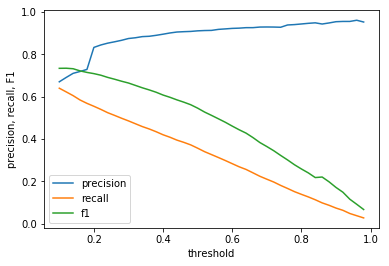

In [37]:
precision_thresholds_average = []
recall_thresholds_average = []
f1_thresholds_average = []
aucs_average = []

for threshold in thresholds:
    col_name = 'agg_vote'+str(round(threshold,2))
    precision_thresholds_average.append(threshold_dictionary[col_name].precision.mean())
    recall_thresholds_average.append(threshold_dictionary[col_name].recall.mean())
    f1_thresholds_average.append(threshold_dictionary[col_name].f1.mean())
    #aucs_average.append(threshold_dictionary[col_name].auc.mean())
        
plt.plot(thresholds,precision_thresholds_average, label = 'precision')
plt.plot(thresholds,recall_thresholds_average, label = 'recall')
plt.plot(thresholds,f1_thresholds_average, label = 'f1')
plt.xlabel('threshold')
plt.ylabel('precision, recall, F1')
plt.legend()

threshold_optimal = thresholds[np.argmax(f1_thresholds_average)]
threshold_optimal

#### Performance

In [39]:
threshold = threshold_optimal
#manual override
threshold = 0.12
for stream in streams_predictions:
    sum_of_votes = results_use[stream].drop(['ra','dec','pmra','pmdec', 'ang_coord_1', 'ang_coord_2', 'ang_coord_3', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag', 'stream_mask'],axis=1).sum(axis=1)
    results_use[stream]['avg_of_votes'] = sum_of_votes / number_of_votes
    results_use[stream]['agg_vote'] = np.where(results_use[stream].avg_of_votes > threshold, True, False)

stream_name_ens = []
true_positives = []
false_positives = []
true_negatives = []
false_negatives = []

for stream_index in range(len(streams_predictions)):
    #y_test = results_use[streams_predictions[stream_index]].stream_mask
    #y_pred = results_use[streams_predictions[stream_index]].agg_vote
    #Truly in Cluster
    #X_correct = results_use[streams_predictions[stream_index]][y_test & y_pred] #predicted in cluster (true positives)
    #X_incorrect = results_use[streams_predictions[stream_index]][y_test & ~y_pred] #predicted not in cluster (false negative)
    #Truly not in Cluster
    #X2_correct = results_use[streams_predictions[stream_index]][~y_test & ~y_pred] #predicted not in cluster (true negative)
    #X2_incorrect = results_use[streams_predictions[stream_index]][~y_test & y_pred] #predicted in cluster (false positive)
    
    temp = results_use[streams_predictions[stream_index]]
    temp2 = temp[temp['stream_mask']==True]
    X_correct = temp2[temp2['agg_vote']==True] #true positive
    X_incorrect = temp2[temp2['agg_vote']==False] #false negative
    
    temp3 = temp[temp['stream_mask']==False]
    X2_correct = temp3[temp3['agg_vote']==False] #true negative
    X2_incorrect = temp3[temp3['agg_vote']==True] #false positive
    
    stream_name_ens.append(streams_predictions[stream_index])
    true_positives.append(len(X_correct))
    false_positives.append(len(X2_incorrect))
    true_negatives.append(len(X2_correct))
    false_negatives.append(len(X_incorrect))
    
final_result = pd.DataFrame()
final_result['stream']= stream_name_ens
final_result['true_positives']=true_positives
final_result['false_positives']=false_positives
final_result['true_negatives']=true_negatives
final_result['false_negatives']=false_negatives
final_result['precision'] = final_result.true_positives / (final_result.true_positives + final_result.false_positives)
final_result['recall'] = final_result.true_positives / (final_result.true_positives + final_result.false_negatives)
final_result['f1'] = 2*(final_result.precision * final_result.recall)/(final_result.precision + final_result.recall)
beta = 0.1
final_result['f1_prec_10'] = (1 + beta**2) * (final_result.precision * final_result.recall) / (beta**2 * final_result.precision + final_result.recall)
beta = 0.2
final_result['f1_prec_5'] = (1 + beta**2) * (final_result.precision * final_result.recall) / (beta**2 * final_result.precision + final_result.recall)
beta = 5
final_result['f1_rec_5'] = (1 + beta**2) * (final_result.precision * final_result.recall) / (beta**2 * final_result.precision + final_result.recall)
beta = 10
final_result['f1_rec_10'] = (1 + beta**2) * (final_result.precision * final_result.recall) / (beta**2 * final_result.precision + final_result.recall)

In [40]:
final_result.to_csv('ensemble3_20200307_3_models.csv')
final_result

,stream,true_positives,false_positives,true_negatives,false_negatives,precision,recall,f1,f1_prec_10,f1_prec_5,f1_rec_5,f1_rec_10
0,stream-9528,38,48,44952,236,0.441860,0.138686,0.211111,0.432499,0.407591,0.142445,0.139635
1,stream-2805,350,121,104429,280,0.743100,0.555556,0.635786,0.740624,0.733575,0.561001,0.556947
2,stream-247,577,219,133881,230,0.724874,0.714994,0.719900,0.724775,0.724489,0.715369,0.715090
3,stream-4717,250,93,86907,284,0.728863,0.468165,0.570125,0.724867,0.713580,0.474695,0.469829
4,stream-5402,12,16,86384,509,0.428571,0.023033,0.043716,0.364950,0.255528,0.023903,0.023250
5,stream-5713,454,123,136527,385,0.786828,0.541120,0.641243,0.783307,0.773323,0.547699,0.542799
6,stream-1519,791,183,176817,274,0.812115,0.742723,0.775871,0.811364,0.809207,0.745172,0.743352
7,stream-4807,46,26,30574,141,0.638889,0.245989,0.355212,0.628943,0.601912,0.251949,0.247496
8,stream-1101,1028,313,265637,574,0.766592,0.641698,0.698607,0.765118,0.760896,0.645744,0.642735


In [41]:
final_result.mean()

true_positives        394.000000
false_positives       126.888889
true_negatives     118456.444444
false_negatives       323.666667
precision               0.674633
recall                  0.452440
f1                      0.516841
f1_prec_10              0.664050
f1_prec_5               0.642234
f1_rec_5                0.456442
f1_rec_10               0.453459
dtype: float64

In [32]:
#results_use[streams_predictions[2]]

##### Visualization

In [42]:
for stream in streams_predictions:
    sum_of_votes = results_use[stream].drop(['ra','dec','pmra','pmdec', 'ang_coord_1', 'ang_coord_2', 'ang_coord_3', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag', 'stream_mask'],axis=1).sum(axis=1)
    results_use[stream]['avg_of_votes'] = sum_of_votes / number_of_votes
    results_use[stream]['agg_vote'] = np.where(results_use[stream].avg_of_votes > threshold_optimal, True, False)

In [43]:
results_use['stream-2805']

,ra,dec,pmra,pmdec,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,stream_mask,ra_rad,dec_rad,...,voter_67,voter_68,voter_69,voter_70,voter_71,voter_72,voter_73,voter_74,avg_of_votes,agg_vote
681,29.590643,-46.895453,4.964912,0.804265,19.386367,19.658589,18.941112,True,0.516454,-0.818480,...,False,False,False,True,False,True,True,True,0.644275,True
626,107.536615,27.942703,0.954371,-1.828700,19.524426,19.898325,18.943114,True,1.876868,0.487692,...,False,False,False,False,False,False,False,False,0.031948,False
329,37.740671,-43.465467,5.304870,0.508659,19.345646,19.622050,18.909307,True,0.658699,-0.758616,...,False,False,False,False,False,True,False,False,0.403806,True
620,120.220147,36.952383,1.541237,0.015918,18.925494,19.329944,18.327692,True,2.098237,0.644941,...,False,False,False,False,False,False,False,False,0.050574,False
399,77.358064,-6.825724,5.232020,0.290729,18.141432,18.600492,17.521939,True,1.350153,-0.119131,...,False,True,True,False,True,True,True,False,0.813610,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165219,273.211303,-6.108567,-3.436963,-1.582297,20.292070,21.292326,19.546663,False,4.768437,-0.106615,...,False,False,False,False,False,False,False,False,0.062986,False
91303,91.740934,4.927139,0.043680,-1.334237,19.691568,20.229595,18.972334,False,1.601181,0.085995,...,False,False,False,False,False,False,False,False,0.022796,False
156656,249.901640,-41.166563,-6.827628,-9.973758,20.518738,21.099907,19.909754,False,4.361606,-0.718492,...,False,False,False,False,False,False,False,False,0.049223,False
143034,225.199297,-48.548303,-2.076449,-2.333050,20.226715,20.873856,19.509138,False,3.930469,-0.847328,...,False,False,False,False,False,False,False,False,0.041657,False


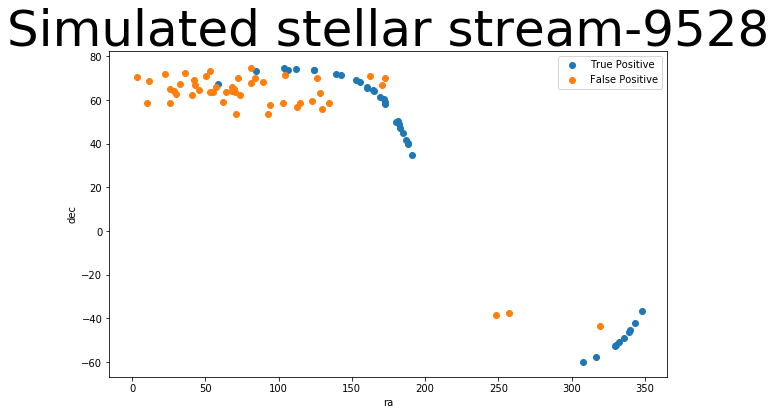

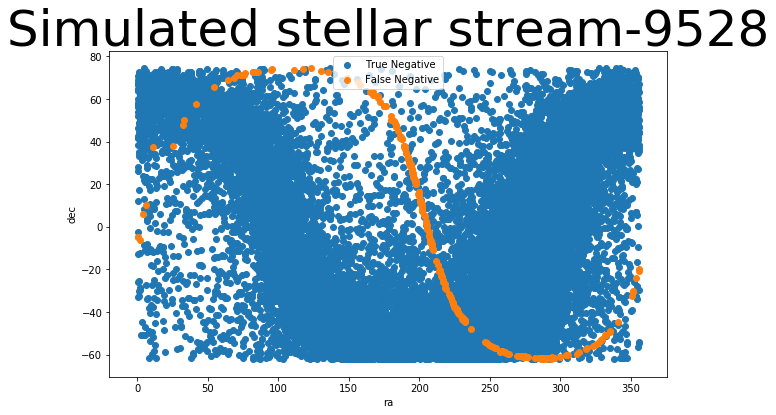

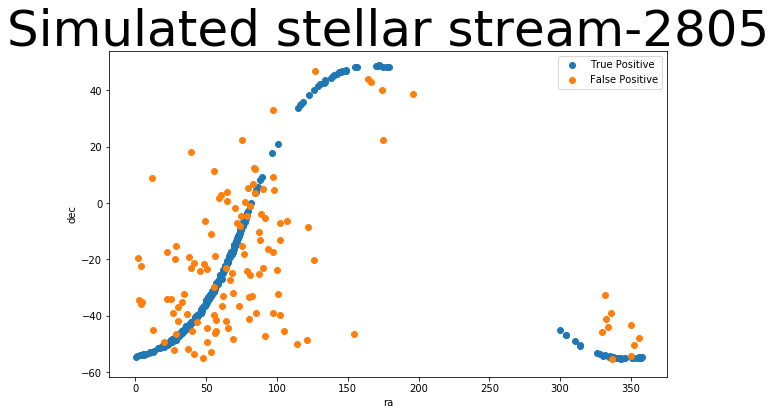

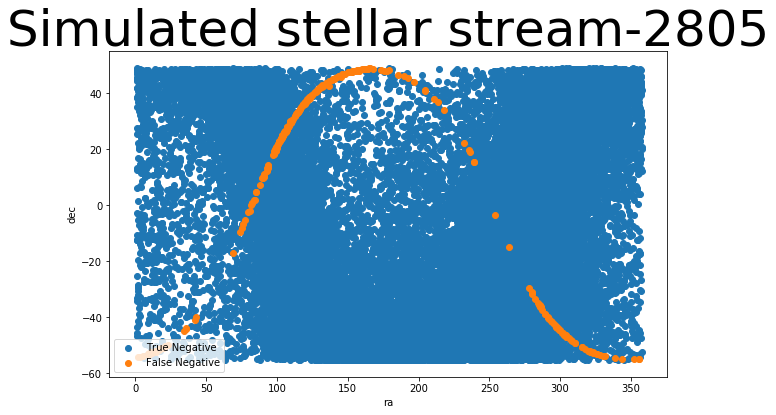

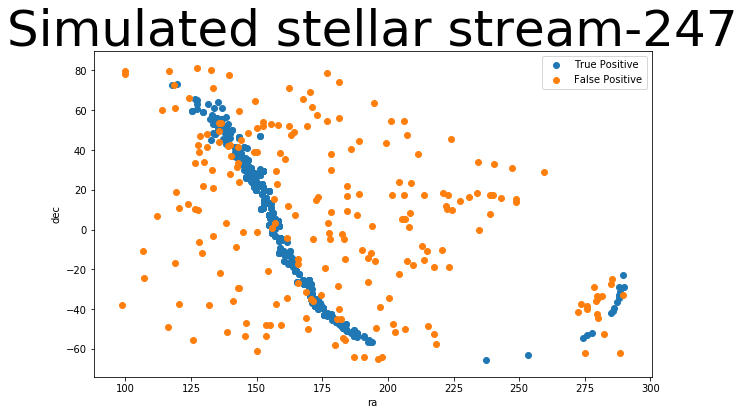

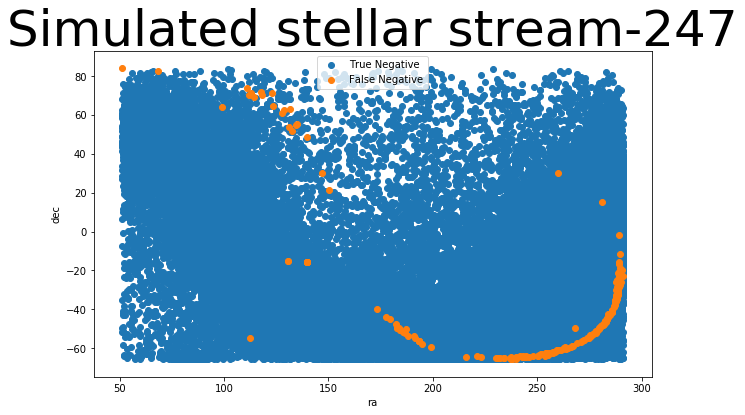

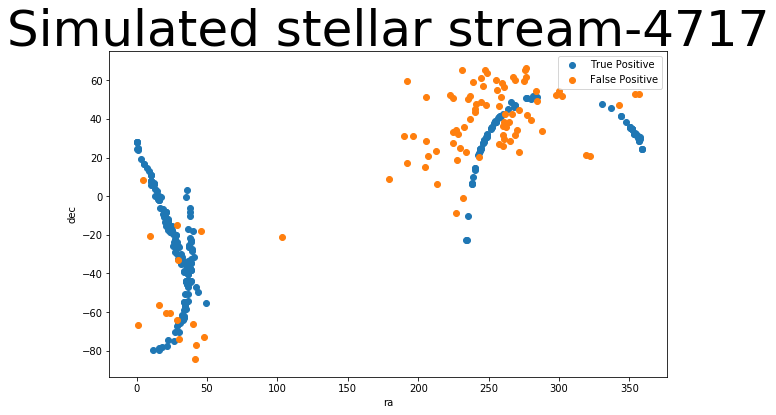

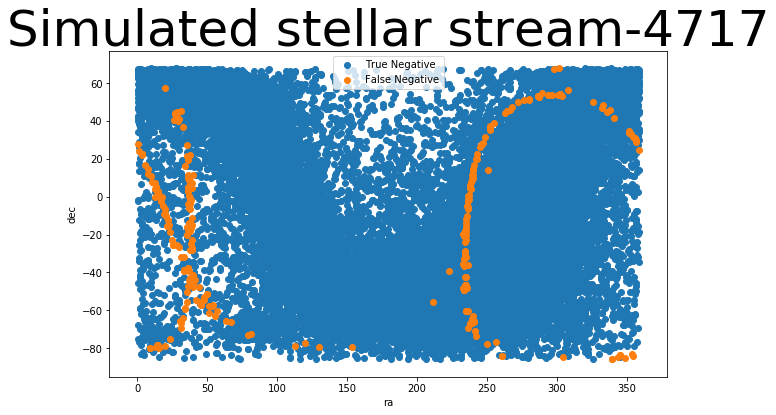

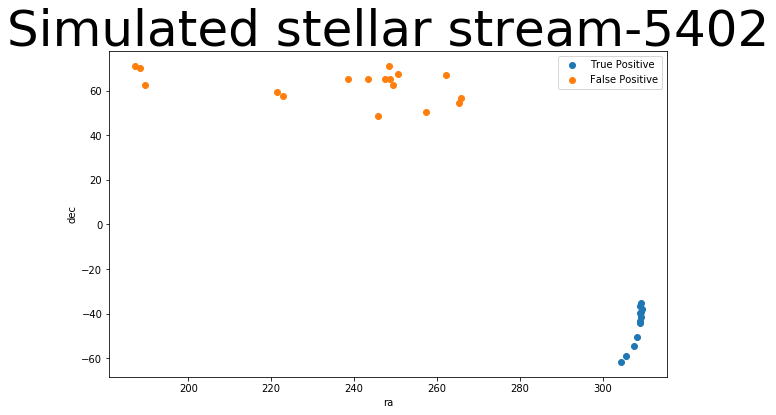

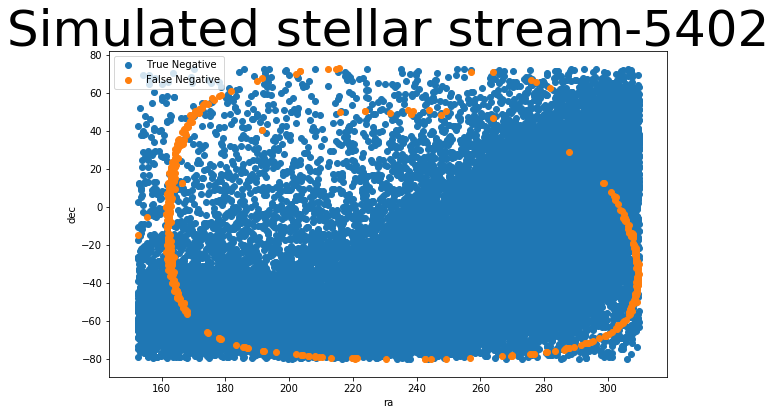

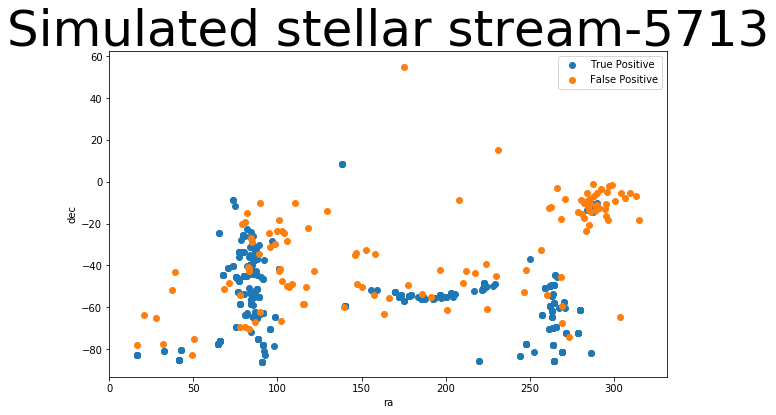

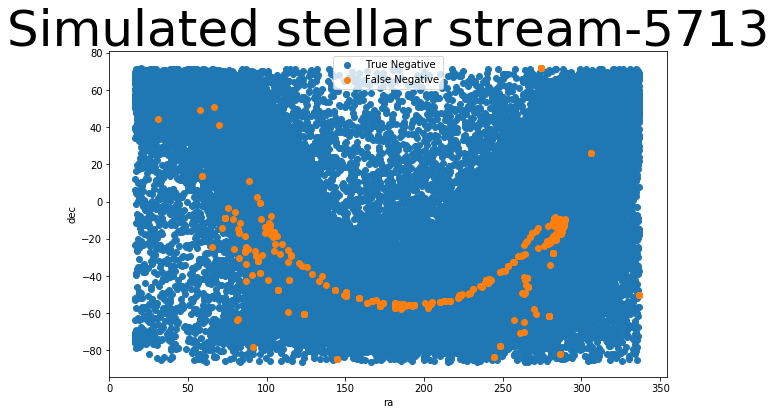

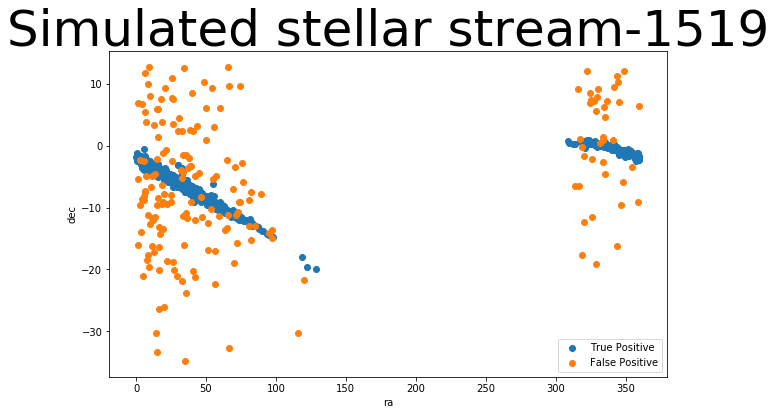

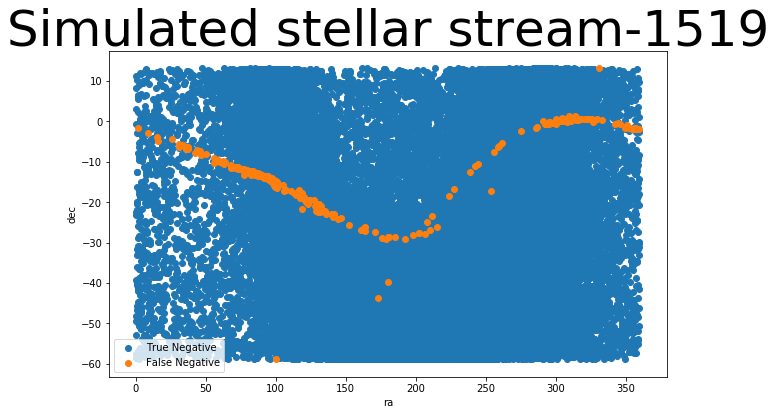

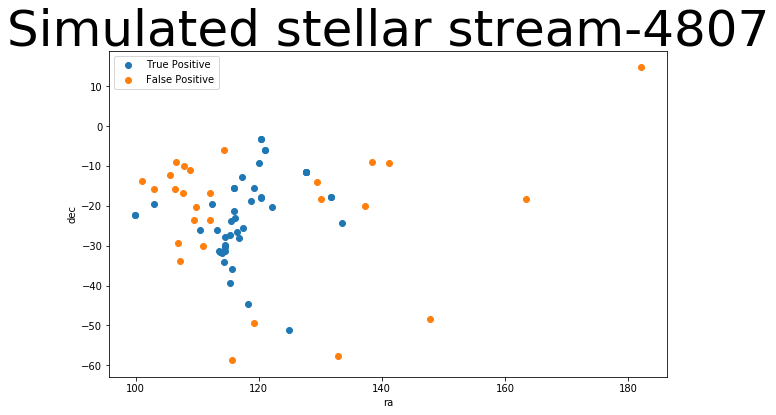

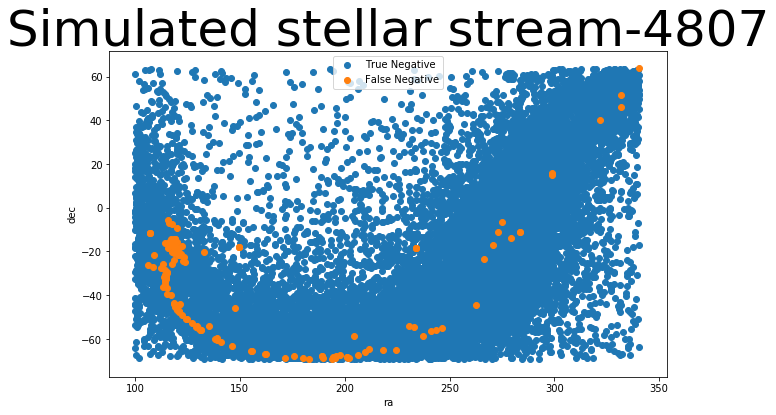

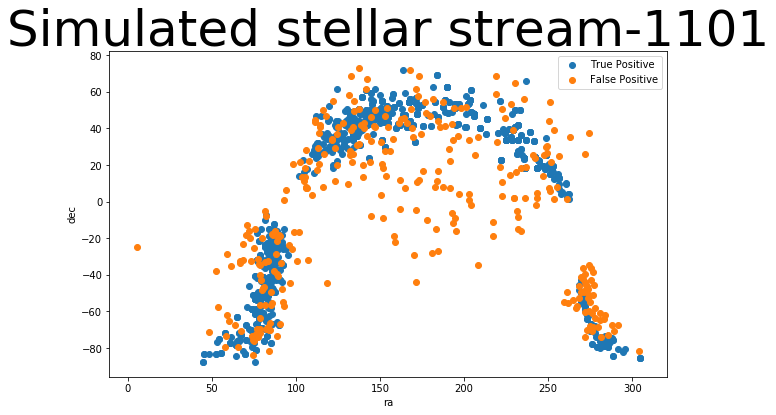

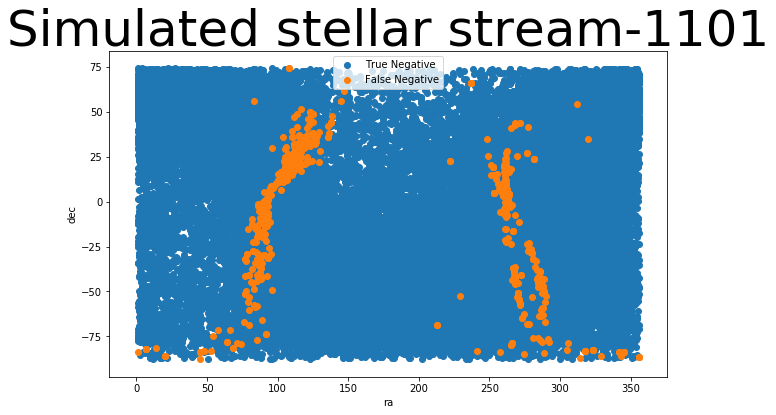

In [51]:
for item in range(len(streams_predictions)):
    #Plot performance for Stream in index from 0 to len(streams)
    stream_index = item
    y_test = results_use[streams_predictions[stream_index]].stream_mask
    y_pred = results_use[streams_predictions[stream_index]].agg_vote
    #Truly in Cluster
    X_correct = results_use[streams_predictions[stream_index]][y_test & y_pred] #predicted in cluster (true positives)
    X_incorrect = results_use[streams_predictions[stream_index]][y_test & ~y_pred] #predicted not in cluster (false negative)
    #Truly not in Cluster
    X2_correct = results_use[streams_predictions[stream_index]][~y_test & ~y_pred] #predicted not in cluster (true negative)
    X2_incorrect = results_use[streams_predictions[stream_index]][~y_test & y_pred] #predicted in cluster (false positive)

    X_correct['label']=1
    X_incorrect['label']=1
    X2_correct['label']=0
    X2_incorrect['label']=0

    #visualize true and false positives
    plt.figure(figsize = (10,6))
    plt.scatter(X_correct['ra'], X_correct['dec'], label = "True Positive")
    plt.scatter(X2_incorrect['ra'], X2_incorrect['dec'], label = "False Positive")
    plt.xlabel('ra')
    plt.ylabel('dec')
    plt.title('Simulated stellar ' + streams_predictions[stream_index], fontsize = 50)
    plt.legend()

    plt.figure(figsize = (10,6))
    plt.scatter(X2_correct['ra'], X2_correct['dec'], label = "True Negative")
    plt.scatter(X_incorrect['ra'], X_incorrect['dec'], label = "False Negative")
    plt.xlabel('ra')
    plt.ylabel('dec')
    plt.title('Simulated stellar ' + streams_predictions[stream_index], fontsize = 50)
    plt.legend()



    #plt.scatter(X2_correct['pmra'], X2_correct['pmdec'])
    #plt.scatter(X_incorrect['pmra'], X_incorrect['pmdec'])

    #This takes true positives and false positives
    X_pred_pos = X_correct.append(X2_incorrect, ignore_index = False, sort = True)
    #print(streams_predictions[stream_index])
    #print('Number of true positives is ' + str(len(X_correct)))
    #print('Number of false positives is ' + str(len(X2_incorrect)))
    #print('Number of true negatives is ' + str(len(X2_correct)))
    #print('Number of false negatives is ' + str(len(X_incorrect)))


In [49]:
#visualize true and false positives
streams_predictions

['stream-9528',
 'stream-2805',
 'stream-247',
 'stream-4717',
 'stream-5402',
 'stream-5713',
 'stream-1519',
 'stream-4807',
 'stream-1101']

##### Evaluate performance on GD1

In [168]:
filename = "~/Data/gd1_in_gaia.h5"
dataset = pd.read_hdf(filename, 'df')

In [169]:
#separate the data points that belong to GD1
dataset_gd1 = dataset[dataset['pm_mask'] == True]
dataset_gd1 = dataset_gd1[dataset_gd1['gi_cmd_mask'] == True]
dataset_gd1 = dataset_gd1[dataset_gd1['stream_track_mask'] == True]
dataset_gd1['in_gd1'] = 1

#separate the data points that do not belong to GD1 AND have passed through the isochrone filter
dataset_nongd = dataset[(dataset['pm_mask']== False) | (dataset['stream_track_mask'] == False)]
dataset_nongd = dataset_nongd[dataset_nongd['gi_cmd_mask'] == True]
dataset_nongd['in_gd1'] = 0

In [170]:
combined_df = dataset_gd1.append(dataset_nongd, ignore_index = False)
#X = combined_df[['ra','dec','pmra_x', 'pmdec_x']]
#y = combined_df['in_gd1']

In [171]:
len(dataset_gd1), len(dataset_nongd)

(1979, 505945)

In [172]:
#we've searched a wider range of kNN models from which to seek the best 25.
res1 = pd.read_csv('train_models_gd1a.csv', index_col = 0)
res2 = pd.read_csv('train_models_gd1b.csv', index_col = 0)
res = res1.append(res2, ignore_index = True)
res3 = pd.read_csv('train_models_gd1c.csv', index_col = 0)
res = res.append(res3, ignore_index = True)

res['f1']= 2*(res.precision * res.recall)/(res.precision + res.recall)
#res.sort_values(by = 'f1',ascending = False).head(20)
#res.query('f1 > 0.701')
res3 = res.groupby(['k','multiple','training_ratio']).mean().sort_values(by = 'f1',ascending = False)
res3 = res3.reset_index()[['k','multiple','training_ratio']]
tuples_gd1 = [(list(res3.k)[i], list(res3.multiple)[i], list(res3.training_ratio)[i]) for i in range(len(res3))]
len(tuples_gd1)

300

In [173]:
res.k.describe()

count    300.000000
mean      12.166667
std        7.460412
min        1.000000
25%        5.000000
50%       12.000000
75%       19.000000
max       25.000000
Name: k, dtype: float64

In [176]:
len(tuples_try_10)

112

In [25]:
#philip's pre-cut data set
#preselected_test = pd.read_csv("gd1_philip/test_gd1.csv", index_col = 0)
#preselected_train = pd.read_csv("gd1_philip/train_gd1.csv", index_col = 0)

In [34]:
#split data into training and training data set
training_ratio = 0.1
stream_train, stream_test = train_test_split(dataset_gd1, test_size=1-training_ratio)

votes = []

number_of_votes = 75
for voter in tqdm(tuples_gd1[:number_of_votes]):

    k_optimal = voter[0]
    multiple = voter[1]
    training_ratio = voter[2]


#     train_points = len(stream_train) * multiple

#     noise_train = dataset_nongd.sample(n=train_points,random_state = 25)
#     leftover_noise = pd.concat([dataset_nongd,noise_train]).drop_duplicates(keep=False)
#     leftover_noise = leftover_noise.append(stream_test, ignore_index = False, sort = True)
#     n_points = round(len(dataset_nongd)*0.8)
#     noise_test = leftover_noise.sample(n=n_points,random_state = 25)
#     noise_test.in_gd1 = 0

    #use Philip's cut
    training_data = preselected_train[['ra', 'dec', 'pmra', 'pmdec', 'label']]
    
    #use Philip's cut
    testing_data = preselected_test[['ra', 'dec', 'pmra', 'pmdec', 'label']]

    #differentiate training and test data's X and y variables
    X_train = training_data[['ra', 'dec', 'pmra', 'pmdec']]
    y_train = training_data.label

    X_test = testing_data[['ra', 'dec', 'pmra', 'pmdec']]
    y_test = testing_data.label

    #scale the features using standard scaler (scaling not required for logistic regression)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit(X_train).transform(X_train)
    X_test_scaled = scaler.fit(X_test).transform(X_test)

    precision, recall, accuracy, auc, y_pred, y_true = knn_model(X_train_scaled, X_test_scaled, y_train, y_test, k_optimal)
    votes.append(y_pred)

100%|██████████| 25/25 [03:08<00:00,  6.76s/it]


In [35]:
for i in range(len(votes)):
    name_of_vote = 'voter_' + str(i)
    testing_data[name_of_vote] = votes[i]

In [36]:
testing_data.to_csv('ensemble_gd1_20191209_tunedgd1_precut.csv')

In [43]:
tps = []
fps = []
tns = []
fns = []
precs = []
recs = []
f1s = []
aucs = []


#threshold = threshold_optimal
#thresholds_tune = [0.04, 0.08, 0.12,0.16,0.2,0.24,0.28,0.32,0.36,0.4,0.44,0.48]
thresholds_tune = [0.24]
for threshold_test in thresholds_tune:
    threshold = threshold_test
    sum_of_votes = testing_data.drop(['ra','dec','pmra','pmdec','label'],axis=1).sum(axis=1)
    testing_data['avg_of_votes'] = sum_of_votes / number_of_votes
    testing_data['agg_vote'] = np.where(testing_data.avg_of_votes > threshold, True, False)

    y_test = testing_data.label
    y_pred = testing_data.agg_vote
    #Truly in Cluster
    X_correct = testing_data[y_test & y_pred] #predicted in cluster (true positives)
    X_incorrect = testing_data[y_test & ~y_pred] #predicted not in cluster (false negative)
    #Truly not in Cluster
    X2_correct = testing_data[~y_test & ~y_pred] #predicted not in cluster (true negative)
    X2_incorrect = testing_data[~y_test & y_pred] #predicted in cluster (false positive)
    precision_gd1 = len(X_correct)/(len(X_correct) + len(X2_incorrect))
    recall_gd1 = len(X_correct)/(len(X_correct) + len(X_incorrect))
    f1_gd1 = 2*(precision_gd1 * recall_gd1)/(precision_gd1+recall_gd1)

    #calculate the AUC
    fpr, tpr, thresholds = metrics.roc_curve(y_test, testing_data.avg_of_votes)
    auc = metrics.auc(fpr, tpr)

    tps.append(len(X_correct))
    fps.append(len(X2_incorrect))
    tns.append(len(X2_correct))
    fns.append(len(X_incorrect))
    precs.append(precision_gd1)
    recs.append(recall_gd1)
    f1s.append(f1_gd1)
    aucs.append(auc)
    
    print('Number of true positives is ' + str(len(X_correct)))
    print('Number of false positives is ' + str(len(X2_incorrect)))
    print('Number of true negatives is ' + str(len(X2_correct)))
    print('Number of false negatives is ' + str(len(X_incorrect)))
    print('Precision is ' + str(precision_gd1))
    print('Recall is ' + str(recall_gd1))
    print('F1 score is ' + str(f1_gd1))
    print('The AUC is ' + str(auc))

Number of true positives is 1050
Number of false positives is 536
Number of true negatives is 454919
Number of false negatives is 731
Precision is 0.6620428751576293
Recall is 0.5895564289724874
F1 score is 0.6237006237006237
The AUC is 0.8418606117614575


In [44]:
tps = []
fps = []
tns = []
fns = []
precs = []
recs = []
f1s = []
aucs = []


thresholds_tune = [0.04, 0.08, 0.12,0.16,0.2,0.24,0.28,0.32,0.36,0.4,0.44,0.48]
#thresholds_tune = [0.24]
for threshold_test in thresholds_tune:
    threshold = threshold_test
    sum_of_votes = testing_data.drop(['ra','dec','pmra','pmdec','label'],axis=1).sum(axis=1)
    testing_data['avg_of_votes'] = sum_of_votes / number_of_votes
    testing_data['agg_vote'] = np.where(testing_data.avg_of_votes > threshold, True, False)

    y_test = testing_data.label
    y_pred = testing_data.agg_vote
    #Truly in Cluster
    X_correct = testing_data[y_test & y_pred] #predicted in cluster (true positives)
    X_incorrect = testing_data[y_test & ~y_pred] #predicted not in cluster (false negative)
    #Truly not in Cluster
    X2_correct = testing_data[~y_test & ~y_pred] #predicted not in cluster (true negative)
    X2_incorrect = testing_data[~y_test & y_pred] #predicted in cluster (false positive)
    precision_gd1 = len(X_correct)/(len(X_correct) + len(X2_incorrect))
    recall_gd1 = len(X_correct)/(len(X_correct) + len(X_incorrect))
    f1_gd1 = 2*(precision_gd1 * recall_gd1)/(precision_gd1+recall_gd1)

    #calculate the AUC
    fpr, tpr, thresholds = metrics.roc_curve(y_test, testing_data.avg_of_votes)
    auc = metrics.auc(fpr, tpr)

    tps.append(len(X_correct))
    fps.append(len(X2_incorrect))
    tns.append(len(X2_correct))
    fns.append(len(X_incorrect))
    precs.append(precision_gd1)
    recs.append(recall_gd1)
    f1s.append(f1_gd1)
    aucs.append(auc)
    
#     print('Number of true positives is ' + str(len(X_correct)))
#     print('Number of false positives is ' + str(len(X2_incorrect)))
#     print('Number of true negatives is ' + str(len(X2_correct)))
#     print('Number of false negatives is ' + str(len(X_incorrect)))
#     print('Precision is ' + str(precision_gd1))
#     print('Recall is ' + str(recall_gd1))
#     print('F1 score is ' + str(f1_gd1))
#     print('The AUC is ' + str(auc))

Text(0.5, 0, 'threshold')

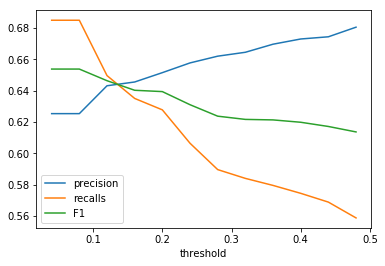

In [45]:
plt.plot(thresholds_tune, precs, label = 'precision')
plt.plot(thresholds_tune, recs, label = 'recalls')
plt.plot(thresholds_tune, f1s, label = 'F1')
plt.legend()
plt.xlabel('threshold')

In [55]:
len(stream_train), len(stream_test)
len(X_train), len(X_test), len(y_train), len(y_test)
len(leftover_noise.columns), len(dataset_nongd.columns)
testing_data.in_gd1.describe()

count    572976.000000
mean          0.005791
std           0.075877
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: in_gd1, dtype: float64

In [58]:
noise_test.in_gd1.describe()

count    571194.000000
mean          0.002689
std           0.051787
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: in_gd1, dtype: float64

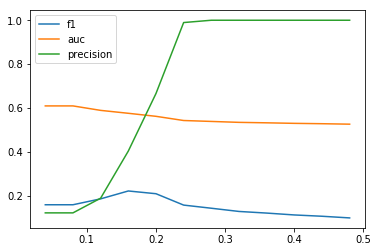

In [61]:
plt.plot(thresholds_tune, f1s, label = 'f1')
plt.plot(thresholds_tune, aucs, label = 'auc')
plt.plot(thresholds_tune, precs, label = 'precision')
plt.legend()

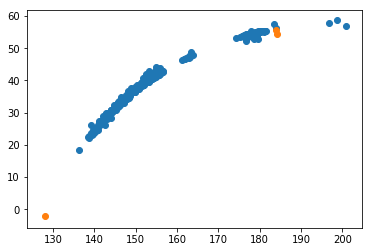

In [66]:
plt.scatter(X_correct['ra'], X_correct['dec'])
plt.scatter(X2_incorrect['ra'], X2_incorrect['dec'])

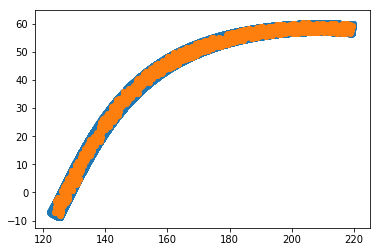

In [67]:
plt.scatter(X2_correct['ra'], X2_correct['dec'])
plt.scatter(X_incorrect['ra'], X_incorrect['dec'])

# Tune Random Forest model

In [41]:
#tuning for threshold
params= []
f1_vals = []

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 300, num = 3)] #start= 200,stop = 2000, num = 10
# Number of features to consider at every split
max_features = ['auto'] #'sqrt'
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 50, num = 3)] #10,110, num = 11
#max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2,5] #2,5,10
# Minimum number of samples required at each leaf node
min_samples_leaf = [1,2] #1,2,4
# Method of selecting samples for training each tree
bootstrap = [True] #False

total = 3 * 1 * 3 * 2 * 2 * 1
count = 0

for n_estimator in tqdm(n_estimators):
    for max_feature in max_features:
        for depth in max_depth:
            for min_split in min_samples_split:
                for min_leaf in min_samples_leaf:
                    for bootstrap_option in bootstrap:
                        count += 1
                        stream_name_rf = []
                        true_positives = []
                        false_positives = []
                        true_negatives = []
                        false_negatives = []
                        y_preds = []
                        testing_datas = []
                        multiple = 150

                        for stream_name in viable_new[:9]:

                            stream_primer1 = 'stream_stars_split/train_known/' + stream_name + "_known_to_model.csv"
                            stream_primer2 = 'stream_stars_split/test_unknown/' + stream_name + "_unknown_to_model.csv"

                            #stars known to model
                            stream_train = pd.read_csv(stream_primer1, index_col = 0)
                            stream_train['stream_mask'] = True
                            #unknown to model
                            stream_test = pd.read_csv(stream_primer2, index_col = 0)
                            stream_test['stream_mask'] = True  

                            #obtain noise points such that:
                            #- the ratio of stream to noise points in the training set is 1:multiple
                            #- the ratio of stream to noise points in the test set is close to the 'real' ratio
                            test_primer = 'stream_stars_split/simulated_noise_points/150_to_1_ratio/'
                            name_test = test_primer + stream_name + "_mul_150_total_noise.csv"

                            train_primer = 'stream_stars_split/simulated_noise_points/400_to_1_ratio/'
                            name_train = train_primer + stream_name + "_mul_400_total_noise.csv"

                            noise_test = pd.read_csv(name_test, index_col = 0)
                            noise_points = pd.read_csv(name_train, index_col = 0)

                            #add back the test points into the muck and assume they're background stars from which to draw
                            noise_points = noise_points.append(stream_test, ignore_index = False, sort = True)
                            train_points = len(stream_train) * multiple

                            #label our data as "not part of the stream"
                            noise_points['stream_mask'] = False

                            msk2 = np.random.rand(len(noise_points)) < (train_points / len(noise_points))
                            noise_train = noise_points[msk2]
                            #noise_test = noise_points[~msk2]



                            #combine my stream and noise to obtain complete training and test data set
                            training_data = stream_train.append(noise_train, ignore_index = False, sort = True)
                            training_data = training_data[['ra', 'dec', 'pmra', 'pmdec', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag', 'stream_mask']]

                            testing_data = stream_test.append(noise_test, ignore_index = False, sort = True)
                            testing_data = testing_data[['ra', 'dec', 'pmra', 'pmdec',  'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag', 'stream_mask']]

                            #Convert to Angular Coordinates
                            #ang_coord_1 = -pmdec * cos(ra) - pmra * cos(dec) * sin(dec) * sin(ra)
                            #ang_coord_2 = -pmra * cos(dec) * cos(ra) * sin(dec) + pmdec * sin(ra)
                            #ang_coord_3 =  pmra ( cos(dec) * cos(dec) )

                            deg2rad = lambda deg: deg/180.*np.pi

                            #Convert data to angular velocities
                            training_data['ra_rad'] = deg2rad(training_data['ra'])
                            training_data['dec_rad'] = deg2rad(training_data['dec'])

                            training_data['ang_coord_1'] = -1 * training_data.pmdec * ( np.cos(training_data.ra_rad)) -  training_data.pmdec * np.cos(training_data.dec_rad) * np.sin(training_data.dec_rad * np.sin(training_data.ra_rad))
                            training_data['ang_coord_2'] = -1 * training_data.pmra *    np.cos(training_data.dec_rad) * np.cos(training_data.ra_rad) * np.sin(training_data.dec_rad + training_data.pmra * np.sin(training_data.ra_rad))
                            training_data['ang_coord_3'] = training_data.pmra * ( np.cos(training_data.dec_rad) * np.cos(training_data.dec_rad) )

                            testing_data['ra_rad'] = deg2rad(testing_data['ra'])
                            testing_data['dec_rad'] = deg2rad(testing_data['dec'])

                            testing_data['ang_coord_1'] = -1 * testing_data.pmdec * ( np.cos(testing_data.ra_rad)) -  testing_data.pmdec * np.cos(testing_data.dec_rad) * np.sin(testing_data.dec_rad * np.sin(testing_data.ra_rad))
                            testing_data['ang_coord_2'] = -1 * testing_data.pmra *    np.cos(testing_data.dec_rad) * np.cos(testing_data.ra_rad) * np.sin(testing_data.dec_rad + testing_data.pmra * np.sin(testing_data.ra_rad))
                            testing_data['ang_coord_3'] = testing_data.pmra * ( np.cos(testing_data.dec_rad) * np.cos(testing_data.dec_rad) )


                            #differentiate training and test data's X and y variables
                            #X_train = training_data[['x', 'y', 'z', 'vx', 'vy', 'vz']] #[['ra', 'dec', 'pmra', 'pmdec']]
                            #y_train = training_data.stream_mask

                            #X_test = testing_data[['x', 'y', 'z', 'vx', 'vy', 'vz']] #[['ra', 'dec', 'pmra', 'pmdec']]
                            #y_test = testing_data.stream_mask


                            #differentiate training and test data's X and y variables
                            X_train = training_data[['ra', 'dec', 'pmra', 'pmdec','ang_coord_1', 'ang_coord_2', 'ang_coord_3', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag']]
                            y_train = training_data.stream_mask

                            X_test = testing_data[['ra', 'dec', 'pmra', 'pmdec','ang_coord_1', 'ang_coord_2', 'ang_coord_3', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag']]
                            y_test = testing_data.stream_mask


                            #scale the features using standard scaler (scaling not required for logistic regression)
                            scaler = StandardScaler()
                            X_train_scaled = scaler.fit(X_train).transform(X_train)
                            X_test_scaled = scaler.fit(X_test).transform(X_test)

                            precision, recall, accuracy, auc, y_pred, y_true = random_forest_model(X_train_scaled, X_test_scaled, y_train, y_test, 
                                                                                                   n_trees = n_estimator, criterion = "gini", max_depth = depth,
                                                                                                   min_samples_split = min_split, min_samples_leaf = min_leaf, 
                                                                                                   min_weight_fraction_leaf = 0, max_features = max_feature, 
                                                                                                   max_leaf_nodes = None, min_impurity_decrease = 0, 
                                                                                                   min_impurity_split = 1e-7, bootstrap = bootstrap_option,
                                                                                                   oob_score = False, n_jobs = 1, 
                                                                                                   random_state = None, verbose = 0, warm_start = False)


                            #y_test = results_use[streams_threshold_tuning[stream_index]].stream_mask
                            #y_pred = results_use[streams_threshold_tuning[stream_index]][col_name]
                            #Truly in Cluster
                            X_correct = testing_data[y_test & y_pred] #predicted in cluster (true positives)
                            X_incorrect = testing_data[y_test & ~y_pred] #predicted not in cluster (false negative)
                            #Truly not in Cluster
                            X2_correct = testing_data[~y_test & ~y_pred] #predicted not in cluster (true negative)
                            X2_incorrect = testing_data[~y_test & y_pred] #predicted in cluster (false positive)

                            stream_name_rf.append(stream_name)
                            true_positives.append(len(X_correct))
                            false_positives.append(len(X2_incorrect))
                            true_negatives.append(len(X2_correct))
                            false_negatives.append(len(X_incorrect))
                            y_preds.append(y_pred)
                            testing_datas.append(testing_data)
                            param = (n_estimator, max_feature, depth, min_split, min_leaf, bootstrap_option)
                            params.append(param)
                        if count%3 == 0:
                            print (str(count) + ' out of ' + str(total) + 'done')

                        final_result_rf = pd.DataFrame()
                        final_result_rf['stream']= stream_name_rf
                        final_result_rf['true_positives']=true_positives
                        final_result_rf['false_positives']=false_positives
                        final_result_rf['true_negatives']=true_negatives
                        final_result_rf['false_negatives']=false_negatives
                        #final_result['auc'] = aucs
                        final_result_rf['precision'] = final_result_rf.true_positives / (final_result_rf.true_positives + final_result_rf.false_positives)
                        final_result_rf['recall'] = final_result_rf.true_positives / (final_result_rf.true_positives + final_result_rf.false_negatives)
                        final_result_rf['f1'] = 2*(final_result_rf.precision * final_result_rf.recall)/(final_result_rf.precision + final_result_rf.recall)
                        beta = 0.1
                        final_result_rf['f1_prec_10'] = (1 + beta**2) * (final_result_rf.precision * final_result_rf.recall) / (beta**2 * final_result_rf.precision + final_result_rf.recall)
                        beta = 0.2
                        final_result_rf['f1_prec_5'] = (1 + beta**2) * (final_result_rf.precision * final_result_rf.recall) / (beta**2 * final_result_rf.precision + final_result_rf.recall)
                        beta = 5
                        final_result_rf['f1_rec_5'] = (1 + beta**2) * (final_result_rf.precision * final_result_rf.recall) / (beta**2 * final_result_rf.precision + final_result_rf.recall)
                        beta = 10
                        final_result_rf['f1_rec_10'] = (1 + beta**2) * (final_result_rf.precision * final_result_rf.recall) / (beta**2 * final_result_rf.precision + final_result_rf.recall)

                        f1_vals.append(final_result_rf[final_result_rf.index.isin(range(9))].f1.mean())

  0%|          | 0/3 [00:00<?, ?it/s]

3 out of 36done
3 out of 36done
3 out of 36done
3 out of 36done
3 out of 36done
3 out of 36done
3 out of 36done
3 out of 36done
3 out of 36done
6 out of 36done
6 out of 36done
6 out of 36done
6 out of 36done
6 out of 36done
6 out of 36done
6 out of 36done
6 out of 36done
6 out of 36done
9 out of 36done
9 out of 36done
9 out of 36done
9 out of 36done
9 out of 36done
9 out of 36done
9 out of 36done
9 out of 36done
9 out of 36done
12 out of 36done
12 out of 36done
12 out of 36done
12 out of 36done
12 out of 36done
12 out of 36done
12 out of 36done
12 out of 36done


 33%|███▎      | 1/3 [05:45<11:31, 345.67s/it]

12 out of 36done
15 out of 36done
15 out of 36done
15 out of 36done
15 out of 36done
15 out of 36done
15 out of 36done
15 out of 36done
15 out of 36done
15 out of 36done
18 out of 36done
18 out of 36done
18 out of 36done
18 out of 36done
18 out of 36done
18 out of 36done
18 out of 36done
18 out of 36done
18 out of 36done
21 out of 36done
21 out of 36done
21 out of 36done
21 out of 36done
21 out of 36done
21 out of 36done
21 out of 36done
21 out of 36done
21 out of 36done
24 out of 36done
24 out of 36done
24 out of 36done
24 out of 36done
24 out of 36done
24 out of 36done
24 out of 36done
24 out of 36done


 67%|██████▋   | 2/3 [15:00<06:48, 408.52s/it]

24 out of 36done
27 out of 36done
27 out of 36done
27 out of 36done
27 out of 36done
27 out of 36done
27 out of 36done
27 out of 36done
27 out of 36done
27 out of 36done
30 out of 36done
30 out of 36done
30 out of 36done
30 out of 36done
30 out of 36done
30 out of 36done
30 out of 36done
30 out of 36done
30 out of 36done
33 out of 36done
33 out of 36done
33 out of 36done
33 out of 36done
33 out of 36done
33 out of 36done
33 out of 36done
33 out of 36done
33 out of 36done
36 out of 36done
36 out of 36done
36 out of 36done
36 out of 36done
36 out of 36done
36 out of 36done
36 out of 36done
36 out of 36done


100%|██████████| 3/3 [27:52<00:00, 517.56s/it]

36 out of 36done


In [45]:
params_opt = params[f1_vals.index(max(f1_vals))]
print(params_opt)
print(max(f1_vals))

(100, 'auto', 10, 5, 1, True)
0.695986056049877


# Test Random Forest model

## Iteration 2 (Recursion)

In [60]:
def rf_recursion(training_streams, testing_streams, correct_X, incorrect_X2, self_labs, final_result_rf, plot_permit, X_correct_cum, X2_incorrect_cum):

    stream_name_rf = []
    true_positives = []
    false_positives = []
    true_negatives = []
    false_negatives = []
    y_preds = []
    testing_datas = []
    training_datas = []
    multiple = 150

    weight_1_options = [0.01, 0.05, 0.1, 0.2, 0.5, 1,5,10,20,50,100,150,200,250,300,400,500,750,1000,2000]
    precisions = []
    recalls = []
    f1s_weights = []

    training_streams_2 = []
    testing_streams_2 = []
    correct_X_2 = []
    incorrect_X2_2 = []
    self_labs_2 = []

    original_index = -1

    #for weight_1 in tqdm(weight_1_options):
    for stream_name in tqdm(viable_new2):
        original_index += 1
        stream_train_prev = training_streams[original_index]
        stream_test_prev = testing_streams[original_index]
        X_correct_prev = correct_X[original_index]
        X2_incorrect_prev = incorrect_X2[original_index]


    #     stellar_stream = pd.read_csv('stream_stars_split/group_c_intelligent/'+stream_name+ '_intelligent_cut.csv')
    #     stellar_stream_valid_b = stellar_stream[stellar_stream['meets_b_req']==True]
    #     #stream_primer1 = 'stream_stars_split/train_known/' + stream_name + "_known_to_model.csv"
    #     #stream_primer2 = 'stream_stars_split/test_unknown/' + stream_name + "_unknown_to_model.csv"

        #stars known to model
        stream_train2 = stream_train_prev.append(stream_test_prev[stream_test_prev.index.isin(X_correct_prev.index)], ignore_index = False)
        stream_train2 = stream_train2.append(stream_test_prev[stream_test_prev.index.isin(X2_incorrect_prev.index)], ignore_index = False)
        stream_train2['stream_mask'] = True

        #unknown to model
        stream_test2 = stream_test_prev[~stream_test_prev.index.isin(X_correct_prev.index)]
        stream_test2['stream_mask'] = True  

        #obtain noise points such that:
        #- the ratio of stream to noise points in the training set is 1:multiple
        #- the ratio of stream to noise points in the test set is close to the 'real' ratio
        test_primer = 'stream_stars_split/simulated_noise_points/ratios_intelligent/'
        name_test = test_primer + stream_name + "_mul_150_total_noise.csv"

        train_primer = 'stream_stars_split/simulated_noise_points/ratios_intelligent/'
        name_train = train_primer + stream_name + "_mul_400_total_noise.csv"

        noise_test = pd.read_csv(name_test, index_col = 0)
        noise_points = pd.read_csv(name_train, index_col = 0)

        #add back the test points into the muck and assume they're background stars from which to draw
        noise_points = noise_points.append(stream_test2, ignore_index = False)
        train_points = len(stream_train2) * multiple

        #label our data as "not part of the stream"
        noise_points['stream_mask'] = False

        msk2 = np.random.rand(len(noise_points)) < (train_points / len(noise_points))
        noise_train = noise_points[msk2]
        #noise_test = noise_points[~msk2]

        #combine my stream and noise to obtain complete training and test data set
        training_data = stream_train2.append(noise_train, ignore_index = False)
        training_data = training_data[['ra', 'dec', 'pmra', 'pmdec', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag', 'stream_mask']]

        testing_data = stream_test2.append(noise_test, ignore_index = False)
        testing_data = testing_data[['ra', 'dec', 'pmra', 'pmdec',  'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag', 'stream_mask']]

        testing_data = self_labs[original_index]
        testing_data = testing_data[~testing_data.index.isin(X_correct_prev.index)] #TP
        testing_data = testing_data[~testing_data.index.isin(X2_incorrect_prev.index)] #FP

        #Convert to Angular Coordinates
        #ang_coord_1 = -pmdec * cos(ra) - pmra * cos(dec) * sin(dec) * sin(ra)
        #ang_coord_2 = -pmra * cos(dec) * cos(ra) * sin(dec) + pmdec * sin(ra)
        #ang_coord_3 =  pmra ( cos(dec) * cos(dec) )

        deg2rad = lambda deg: deg/180.*np.pi

        #Convert data to angular velocities
        training_data['ra_rad'] = deg2rad(training_data['ra'])
        training_data['dec_rad'] = deg2rad(training_data['dec'])

        training_data['ang_coord_1'] = -1 * training_data.pmdec * ( np.cos(training_data.ra_rad)) -  training_data.pmdec * np.cos(training_data.dec_rad) * np.sin(training_data.dec_rad * np.sin(training_data.ra_rad))
        training_data['ang_coord_2'] = -1 * training_data.pmra *    np.cos(training_data.dec_rad) * np.cos(training_data.ra_rad) * np.sin(training_data.dec_rad + training_data.pmra * np.sin(training_data.ra_rad))
        training_data['ang_coord_3'] = training_data.pmra * ( np.cos(training_data.dec_rad) * np.cos(training_data.dec_rad) )


        testing_data['ra_rad'] = deg2rad(testing_data['ra'])
        testing_data['dec_rad'] = deg2rad(testing_data['dec'])

        testing_data['ang_coord_1'] = -1 * testing_data.pmdec * ( np.cos(testing_data.ra_rad)) -  testing_data.pmdec * np.cos(testing_data.dec_rad) * np.sin(testing_data.dec_rad * np.sin(testing_data.ra_rad))
        testing_data['ang_coord_2'] = -1 * testing_data.pmra *    np.cos(testing_data.dec_rad) * np.cos(testing_data.ra_rad) * np.sin(testing_data.dec_rad + testing_data.pmra * np.sin(testing_data.ra_rad))
        testing_data['ang_coord_3'] = testing_data.pmra * ( np.cos(testing_data.dec_rad) * np.cos(testing_data.dec_rad) )

        self_labs_2.append(testing_data)


        #differentiate training and test data's X and y variables
        #X_train = training_data[['x', 'y', 'z', 'vx', 'vy', 'vz']] #[['ra', 'dec', 'pmra', 'pmdec']]
        #y_train = training_data.stream_mask

        #X_test = testing_data[['x', 'y', 'z', 'vx', 'vy', 'vz']] #[['ra', 'dec', 'pmra', 'pmdec']]
        #y_test = testing_data.stream_mask


        #differentiate training and test data's X and y variables
        #X_train = training_data[['ra', 'dec', 'pmra', 'pmdec', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag']]
        X_train = training_data[['ra', 'dec', 'pmra', 'pmdec', 'ang_coord_1', 'ang_coord_2', 'ang_coord_3', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag']]
        y_train = training_data.stream_mask

        #X_test = testing_data[['ra', 'dec', 'pmra', 'pmdec', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag']]
        X_test = testing_data[['ra', 'dec', 'pmra', 'pmdec','ang_coord_1', 'ang_coord_2', 'ang_coord_3', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag']]
        y_test = testing_data.stream_mask


        #scale the features using standard scaler (scaling not required for logistic regression)
        scaler = StandardScaler()
        X_train_scaled = scaler.fit(X_train).transform(X_train)
        X_test_scaled = scaler.fit(X_train).transform(X_test)


        #use mean square sum for angular velocity (wx/N, wy/N, wz/N), where N = sqrt(wx^2 + wy^2 + wz^2)
    #     X_train_scaled = pd.DataFrame(X_train_scaled, columns = ['ra', 'dec', 'pmra', 'pmdec','ang_coord_1', 'ang_coord_2', 'ang_coord_3', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag'])
    #     X_test_scaled = pd.DataFrame(X_test_scaled, columns = ['ra', 'dec', 'pmra', 'pmdec','ang_coord_1', 'ang_coord_2', 'ang_coord_3', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag']) 

    #     X_train_scaled['mean_square_sum'] = X_train_scaled['ang_coord_1']**2+X_train_scaled['ang_coord_2']**2+X_train_scaled['ang_coord_3']**2
    #     X_train_scaled['ang_coord_1'] = X_train_scaled['ang_coord_1'] / X_train_scaled['mean_square_sum']
    #     X_train_scaled['ang_coord_2'] = X_train_scaled['ang_coord_2'] / X_train_scaled['mean_square_sum']
    #     X_train_scaled['ang_coord_3'] = X_train_scaled['ang_coord_3'] / X_train_scaled['mean_square_sum']
    #     X_train_scaled = X_train_scaled.drop(['mean_square_sum'], axis = 1)
    #     X_train_scaled = np.array(X_train_scaled)

    #     X_test_scaled['mean_square_sum'] = X_test_scaled['ang_coord_1']**2+X_test_scaled['ang_coord_2']**2+X_test_scaled['ang_coord_3']**2
    #     X_test_scaled['ang_coord_1'] = X_test_scaled['ang_coord_1'] / X_test_scaled['mean_square_sum']
    #     X_test_scaled['ang_coord_2'] = X_test_scaled['ang_coord_2'] / X_test_scaled['mean_square_sum']
    #     X_test_scaled['ang_coord_3'] = X_test_scaled['ang_coord_3'] / X_test_scaled['mean_square_sum']
    #     X_test_scaled = X_test_scaled.drop(['mean_square_sum'], axis = 1)
    #     X_test_scaled = np.array(X_test_scaled)    

        precision, recall, accuracy, auc, y_pred, y_true, forest = random_forest_model(X_train_scaled, X_test_scaled, y_train, y_test, 
                                                                               n_trees = n_estimator_opt, criterion = "gini", max_depth = depth_opt,
                                                                               min_samples_split = min_split_opt, min_samples_leaf = min_leaf_opt, 
                                                                               min_weight_fraction_leaf = 0, max_features = max_feature_opt, 
                                                                               max_leaf_nodes = None, 
                                                                               min_impurity_split = 1e-7, bootstrap = bootstrap_opt,
                                                                               oob_score = False, n_jobs = 1, 
                                                                               random_state = None, verbose = 0, warm_start = False, class_weight = {0:weight_0,1:weight_1})


        #y_test = results_use[streams_threshold_tuning[stream_index]].stream_mask
        #y_pred = results_use[streams_threshold_tuning[stream_index]][col_name]
        #Truly in Cluster
        X_correct = testing_data[y_test & y_pred] #predicted in cluster (true positives)
        X_incorrect = testing_data[y_test & ~y_pred] #predicted not in cluster (false negative)
        #Truly not in Cluster
        X2_correct = testing_data[~y_test & ~y_pred] #predicted not in cluster (true negative)
        X2_incorrect = testing_data[~y_test & y_pred] #predicted in cluster (false positive)
        
        X_correct_cum[stream_name] = X_correct_cum[stream_name].append(X_correct, ignore_index = False)
        #X_incorrect = X_incorrect_cum.append(X_incorrect, ignore_index = False, sort = True)
        #X2_correct_cum.append(X2_correct, ignore_index = False, sort = True)
        X2_incorrect_cum[stream_name] = X2_incorrect_cum[stream_name].append(X2_incorrect, ignore_index = False)
        X_incorrect_cum[stream_name]=X_incorrect
#         if plot_permit == 'yes':
#             X_correct_cum[stream_name]['species']='TP'
#             X_incorrect_cum[stream_name]['species']='FN'
#             X2_incorrect_cum[stream_name]['species']='FP'

#             sns_frame = X_correct_cum[stream_name].append(X_incorrect_cum[stream_name], ignore_index = False, sort = True)
#             sns_frame = sns_frame.append(X2_incorrect_cum[stream_name], ignore_index = False, sort = True)

#             sns_frame = sns_frame[['ra','dec','pmra','pmdec', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag', 'ang_coord_1', 'ang_coord_2', 'ang_coord_3', 'species']]

#             g = sns.pairplot(sns_frame, hue = 'species')
#             g.fig.suptitle('Pairwise Plot for ' + stream_name, y = 1.08)
        
        stream_name_rf.append(stream_name)
        true_positives.append(len(X_correct))
        false_positives.append(len(X2_incorrect))
        true_negatives.append(len(X2_correct))
        false_negatives.append(len(X_incorrect))
        y_preds.append(y_pred)
        testing_datas.append(testing_data)
        training_datas.append(training_data)
        training_streams_2.append(stream_train2)
        testing_streams_2.append(stream_test2)
        correct_X_2.append(X_correct)
        incorrect_X2_2.append(X2_incorrect)

    final_result_rf2 = pd.DataFrame()
    final_result_rf2['stream']= stream_name_rf
    final_result_rf2['true_positives']=true_positives+recursive_frames[(len(recursive_frames)-1)].true_positives
    final_result_rf2['false_positives']=false_positives+recursive_frames[(len(recursive_frames)-1)].false_positives
    final_result_rf2['true_negatives']=true_negatives
    final_result_rf2['false_negatives']=false_negatives
    #final_result['auc'] = aucs
    final_result_rf2['precision'] = final_result_rf2.true_positives / (final_result_rf2.true_positives + final_result_rf2.false_positives)
    final_result_rf2['recall'] = final_result_rf2.true_positives / (final_result_rf2.true_positives + final_result_rf2.false_negatives)
    final_result_rf2['f1'] = 2*(final_result_rf2.precision * final_result_rf2.recall)/(final_result_rf2.precision + final_result_rf2.recall)
#     beta = 0.1
#     final_result_rf2['f1_prec_10'] = (1 + beta**2) * (final_result_rf2.precision * final_result_rf2.recall) / (beta**2 * final_result_rf2.precision + final_result_rf2.recall)
    beta = 0.5
    final_result_rf2['f0.5'] = (1 + beta**2) * (final_result_rf2.precision * final_result_rf2.recall) / (beta**2 * final_result_rf2.precision + final_result_rf2.recall)
    beta = 2
    final_result_rf2['f2'] = (1 + beta**2) * (final_result_rf2.precision * final_result_rf2.recall) / (beta**2 * final_result_rf2.precision + final_result_rf2.recall)
    final_result_rf2['bal_acc']= (final_result_rf2.true_positives/(final_result_rf2.true_positives + final_result_rf2.false_negatives)+ final_result_rf2.true_negatives/(final_result_rf2.true_negatives+final_result_rf2.false_positives))/2
    final_result_rf2['matt_coef'] = (final_result_rf2.true_positives * final_result_rf2.true_negatives - final_result_rf2.false_positives * final_result_rf2.false_negatives)/((final_result_rf2.true_positives + final_result_rf2.false_positives)*(final_result_rf2.true_positives + final_result_rf2.false_negatives)*(final_result_rf2.true_negatives + final_result_rf2.false_positives)*(final_result_rf2.true_negatives + final_result_rf2.false_negatives))**0.5
    #     precisions.append(final_result_rf.mean().precision)
    #     recalls.append(final_result_rf.mean().recall)
    #     f1s_weights.append(final_result_rf.mean().f1)

    #     recursive_frames.append(final_result_rf2)

    return training_streams_2, testing_streams_2, correct_X_2, incorrect_X2_2, self_labs_2, final_result_rf2, X_correct_cum, X2_incorrect_cum, forest
    

100%|██████████| 8/8 [00:26<00:00,  4.72s/it]


In [37]:
viable_new[:9]

['stream-3775',
 'stream-5489',
 'stream-8137',
 'stream-5406',
 'stream-1698',
 'stream-1667',
 'stream-1012',
 'stream-532',
 'stream-178']

In [40]:
viable_new[:3]+viable_new[4:7]+viable_new[8:9]

['stream-3775',
 'stream-5489',
 'stream-8137',
 'stream-1698',
 'stream-1667',
 'stream-1012',
 'stream-178']

In [46]:
stream_name = 'stream-5402' #viable_new2[4] #stream-5402
test_primer = 'stream_stars_split/simulated_noise_points/ratios_intelligent/'
name_test = test_primer + stream_name + "_mul_150_total_noise.csv"

train_primer = 'stream_stars_split/simulated_noise_points/ratios_intelligent/'
name_train = train_primer + stream_name + "_mul_400_total_noise.csv"

noise_test = pd.read_csv(name_test, index_col = 'source_id')
noise_points = pd.read_csv(name_train, index_col = 'source_id')

noise_points2 = noise_points[~noise_points.index.isin(noise_test.index)]
len(noise_test), len(noise_points), len(noise_points2)

(11400, 30400, 19000)

In [44]:
noise_test

,Unnamed: 0.1,source_id,ra,dec,parallax,parallax_error,pmra,pmdec,b,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,bp_rp,bp_g,g_rp,stream_mask
8052,8052,6309476454413763328,227.523610,-12.768019,0.180598,0.989138,-2.210627,-2.849660,37.816929,20.106518,20.769570,19.350754,1.418816,0.663052,0.755764,False
25294,25294,3476079558511384320,184.297271,-27.051416,-0.037083,0.322305,-8.325304,1.526660,35.198543,18.616072,19.004042,17.933588,1.070454,0.387970,0.682484,False
9960,9960,3494786060935095296,179.960298,-19.691205,-0.252772,0.689997,-2.900706,-3.891713,41.540824,19.670841,20.011190,19.000813,1.010378,0.340349,0.670029,False
18537,18537,6324284848817467520,217.604790,-12.385524,-0.492266,1.274710,-6.755154,-5.429154,43.761068,19.936190,20.698345,18.774563,1.923782,0.762156,1.161627,False
7537,7537,6274054416015746944,211.133417,-24.954994,0.068217,0.326569,-5.589276,0.392565,35.017221,18.844635,19.195030,18.296627,0.898403,0.350395,0.548008,False


In [45]:
noise_points.head()

,source_id,ra,dec,parallax,parallax_error,pmra,pmdec,b,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,bp_rp,bp_g,g_rp,stream_mask
0,6335338376648008192,229.536443,-4.326753,0.010544,0.913392,-10.522595,0.091278,42.636823,20.126968,20.697458,18.727394,1.970064,0.570490,1.399574,False
1,6335411665970687104,229.153256,-3.948323,0.123889,0.600541,-0.385987,-12.812381,43.174589,19.684282,20.369682,18.807777,1.561905,0.685400,0.876505,False
2,6296716347096196864,215.365624,-17.223599,-0.052632,0.288047,-6.913350,1.093881,40.565522,18.884504,19.387394,18.299320,1.088074,0.502890,0.585184,False
3,3571990473199249024,178.345768,-15.266942,-0.063338,0.137531,-8.432233,-0.755149,45.325517,17.658330,17.975906,17.167568,0.808338,0.317575,0.490763,False
4,3536906324170462336,164.433459,-24.118827,0.053413,0.444320,-3.727586,2.404127,31.872258,19.251545,20.007353,18.315256,1.692097,0.755808,0.936289,False


100%|██████████| 8/8 [00:16<00:00,  2.62s/it]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 12%|█▎        | 1/8 [00:01<00:08,  1.20s/it]

 25%|██▌       | 2/8 [00:05<00:13,  2.21s/it]

 38%|███▊      | 3/8 [00:10<00:15,  3.05s/it]

 50%|█████     | 4/8 [00:11<00:09,  2.42s/it]

 62%|██████▎   | 5/8 [00:12<00:05,  1.89s/it]

 75%|███████▌  | 6/8 [00:13<00:03,  1.81s/it]

 88%|████████▊ | 7/8 [00:22<00:03,  3.86s/it]

100%|██████████| 8/8 [00:33<00:00,  5.82s/it]


  7%|▋         | 1/14 [00:33<07:09, 33.04s/it]

  0%|          | 0/8 [00:00<?, ?it/s]

 12%|█▎        | 1/8 [00:01<00:09,  1.29s/it]

 25%|██▌       | 2/8 [00:06<00:13,  2.32s/it]

 38%|███▊      | 3/8 [00:11<00:15,  3.15s/it]

 50%|█████     | 4/8 [00:12<00:10,  2.51s/it]

 62%|██████▎   | 5/8 [00:12<00:05,  1.99s/it]

 75%|███████▌  | 6/8 [00:14<00:03,  1.90s/it]

 88%|████████▊ | 7/8 [00:23<00:03,  3.93s/it]

100%|██████████| 8/8 [00:33<00:00,  5.97s/it]


 14%|█▍        | 2/14 [01:07<06:3

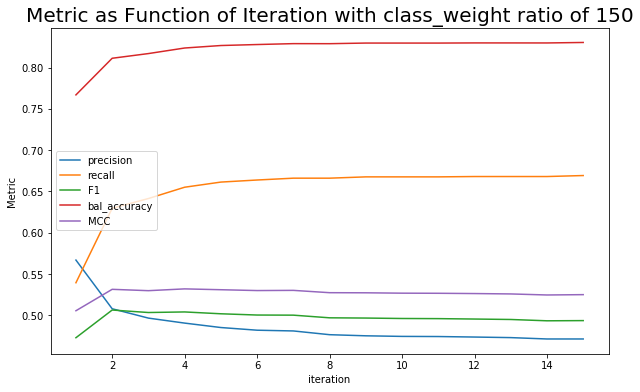

In [76]:
# #define optimal parameters
# n_estimator_opt = params_opt[0]
# max_feature_opt = params_opt[1]
# depth_opt = params_opt[2]
# min_split_opt = params_opt[3]
# min_leaf_opt = params_opt[4]
# bootstrap_opt = params_opt[5]
iteration_1 = []
iteration_final = []
master_forest = []
master_X_train_scaled = []
master_self_labs = []
master_testing_data = []

#weight_1_ops = [1,5,10,25,50,100,150,250,400,500] #all options
weight_1_ops = [150]

for weight_1_option in tqdm(weight_1_ops):
    n_estimator_opt = 200
    max_feature_opt = 'auto'
    depth_opt = 10
    min_split_opt = 2
    min_leaf_opt = 1
    bootstrap_opt = True
    weight_0 = 1
    weight_1 = weight_1_option #high precision model has this = 1; alternatively, balanced model has this = 500

    viable_new2 = viable_new[9:16]+viable_new[17:]
    #viable_new2 = viable_new[:3]+viable_new[4:7]+viable_new[8:9]

    recursive_frames = []

    stream_name_rf = []
    true_positives = []
    false_positives = []
    true_negatives = []
    false_negatives = []
    y_preds = []
    testing_datas = []
    training_datas = []
    multiple = 150
    self_labs = []

    precisions = []
    recalls = []
    f1s_weights = []

    training_streams = []
    testing_streams = []
    correct_X = []
    incorrect_X2 = []
    
    X_correct_cum = {}
    X_incorrect_cum = {}
    X2_correct_cum = {}
    X2_incorrect_cum = {}

    for stream_name in tqdm(viable_new2):

        stellar_stream = pd.read_csv('stream_stars_split/group_c_intelligent/'+stream_name+ '_intelligent_cut.csv')
        stellar_stream_valid_b = stellar_stream[stellar_stream['meets_b_req']==True]
        #stream_primer1 = 'stream_stars_split/train_known/' + stream_name + "_known_to_model.csv"
        #stream_primer2 = 'stream_stars_split/test_unknown/' + stream_name + "_unknown_to_model.csv"

        #stars known to model
        stream_train = stellar_stream_valid_b[stellar_stream_valid_b.known_to_model==True]
        stream_train['stream_mask'] = True
        #unknown to model
        stream_test = stellar_stream_valid_b[stellar_stream_valid_b.known_to_model==False]
        stream_test['stream_mask'] = True  

        #obtain noise points such that:
        #- the ratio of stream to noise points in the training set is 1:multiple
        #- the ratio of stream to noise points in the test set is close to the 'real' ratio
        test_primer = 'stream_stars_split/simulated_noise_points/ratios_intelligent/'
        name_test = test_primer + stream_name + "_mul_150_total_noise.csv"

        train_primer = 'stream_stars_split/simulated_noise_points/ratios_intelligent/'
        name_train = train_primer + stream_name + "_mul_400_total_noise.csv"

        noise_test = pd.read_csv(name_test, index_col = 'source_id')
        noise_points = pd.read_csv(name_train, index_col = 'source_id')
        
        #remove points from training pool that are already in the test set so that we aren't training/testing on same data
        noise_points = noise_points[~noise_points.index.isin(noise_test.index)]

        #add back the test points into the muck and assume they're background stars from which to draw
        noise_points = noise_points.append(stream_test, ignore_index = False) #sort = True
        #train_points = len(stream_train) * multiple
        train_points = len(stream_train) * multiple

        #label our data as "not part of the stream"
        noise_points['stream_mask'] = False

        msk2 = np.random.rand(len(noise_points)) < (train_points / len(noise_points))
        noise_train = noise_points[msk2]
        #noise_test = noise_points[~msk2]



        #combine my stream and noise to obtain complete training and test data set
        training_data = stream_train.append(noise_train, ignore_index = False)
        training_data = training_data[['ra', 'dec', 'pmra', 'pmdec', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag', 'stream_mask']]

        testing_data = stream_test.append(noise_test, ignore_index = False)
        testing_data = testing_data[['ra', 'dec', 'pmra', 'pmdec',  'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag', 'stream_mask']]

        #Convert to Angular Coordinates
        #ang_coord_1 = -pmdec * cos(ra) - pmra * cos(dec) * sin(dec) * sin(ra)
        #ang_coord_2 = -pmra * cos(dec) * cos(ra) * sin(dec) + pmdec * sin(ra)
        #ang_coord_3 =  pmra ( cos(dec) * cos(dec) )

        deg2rad = lambda deg: deg/180.*np.pi

        #Convert data to angular velocities
        training_data['ra_rad'] = deg2rad(training_data['ra'])
        training_data['dec_rad'] = deg2rad(training_data['dec'])

        training_data['ang_coord_1'] = -1 * training_data.pmdec * ( np.cos(training_data.ra_rad)) -  training_data.pmdec * np.cos(training_data.dec_rad) * np.sin(training_data.dec_rad * np.sin(training_data.ra_rad))
        training_data['ang_coord_2'] = -1 * training_data.pmra *    np.cos(training_data.dec_rad) * np.cos(training_data.ra_rad) * np.sin(training_data.dec_rad + training_data.pmra * np.sin(training_data.ra_rad))
        training_data['ang_coord_3'] = training_data.pmra * ( np.cos(training_data.dec_rad) * np.cos(training_data.dec_rad) )

        testing_data['ra_rad'] = deg2rad(testing_data['ra'])
        testing_data['dec_rad'] = deg2rad(testing_data['dec'])

        testing_data['ang_coord_1'] = -1 * testing_data.pmdec * ( np.cos(testing_data.ra_rad)) -  testing_data.pmdec * np.cos(testing_data.dec_rad) * np.sin(testing_data.dec_rad * np.sin(testing_data.ra_rad))
        testing_data['ang_coord_2'] = -1 * testing_data.pmra *    np.cos(testing_data.dec_rad) * np.cos(testing_data.ra_rad) * np.sin(testing_data.dec_rad + testing_data.pmra * np.sin(testing_data.ra_rad))
        testing_data['ang_coord_3'] = testing_data.pmra * ( np.cos(testing_data.dec_rad) * np.cos(testing_data.dec_rad) )

        testing_data_eval, testing_data_selflab = train_test_split(testing_data, test_size=0.5)
        self_labs.append(testing_data_selflab)
        master_self_labs.append(self_labs)
        master_testing_data.append(testing_data)

        #differentiate training and test data's X and y variables
        #X_train = training_data[['x', 'y', 'z', 'vx', 'vy', 'vz']] #[['ra', 'dec', 'pmra', 'pmdec']]
        #y_train = training_data.stream_mask

        #X_test = testing_data[['x', 'y', 'z', 'vx', 'vy', 'vz']] #[['ra', 'dec', 'pmra', 'pmdec']]
        #y_test = testing_data.stream_mask


        #differentiate training and test data's X and y variables
        #X_train = training_data[['ra', 'dec', 'pmra', 'pmdec', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag']]
        X_train = training_data[['ra', 'dec', 'pmra', 'pmdec', 'ang_coord_1', 'ang_coord_2', 'ang_coord_3', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag']]
        y_train = training_data.stream_mask

        ##eval
        #X_test = testing_data_eval[['ra', 'dec', 'pmra', 'pmdec', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag']]
        X_test_eval = testing_data_eval[['ra', 'dec', 'pmra', 'pmdec','ang_coord_1', 'ang_coord_2', 'ang_coord_3', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag']]
        y_test_eval = testing_data_eval.stream_mask

        ##self_lab
        #X_test = testing_data_selflab[['ra', 'dec', 'pmra', 'pmdec', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag']]
        X_test_selflab = testing_data_selflab[['ra', 'dec', 'pmra', 'pmdec','ang_coord_1', 'ang_coord_2', 'ang_coord_3', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag']]
        y_test_selflab = testing_data_selflab.stream_mask


        #scale the features using standard scaler (scaling not required for logistic regression)
        scaler = StandardScaler()
        X_train_scaled = scaler.fit(X_train).transform(X_train)
        X_test_scaled_eval = scaler.fit(X_train).transform(X_test_eval)
        X_test_scaled_selflab = scaler.fit(X_train).transform(X_test_selflab)

        #use mean square sum for angular velocity (wx/N, wy/N, wz/N), where N = sqrt(wx^2 + wy^2 + wz^2)
    #     X_train_scaled = pd.DataFrame(X_train_scaled, columns = ['ra', 'dec', 'pmra', 'pmdec','ang_coord_1', 'ang_coord_2', 'ang_coord_3', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag'])
    #     X_test_scaled = pd.DataFrame(X_test_scaled, columns = ['ra', 'dec', 'pmra', 'pmdec','ang_coord_1', 'ang_coord_2', 'ang_coord_3', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag']) 

    #     X_train_scaled['mean_square_sum'] = X_train_scaled['ang_coord_1']**2+X_train_scaled['ang_coord_2']**2+X_train_scaled['ang_coord_3']**2
    #     X_train_scaled['ang_coord_1'] = X_train_scaled['ang_coord_1'] / X_train_scaled['mean_square_sum']
    #     X_train_scaled['ang_coord_2'] = X_train_scaled['ang_coord_2'] / X_train_scaled['mean_square_sum']
    #     X_train_scaled['ang_coord_3'] = X_train_scaled['ang_coord_3'] / X_train_scaled['mean_square_sum']
    #     X_train_scaled = X_train_scaled.drop(['mean_square_sum'], axis = 1)
    #     X_train_scaled = np.array(X_train_scaled)

    #     X_test_scaled['mean_square_sum'] = X_test_scaled['ang_coord_1']**2+X_test_scaled['ang_coord_2']**2+X_test_scaled['ang_coord_3']**2
    #     X_test_scaled['ang_coord_1'] = X_test_scaled['ang_coord_1'] / X_test_scaled['mean_square_sum']
    #     X_test_scaled['ang_coord_2'] = X_test_scaled['ang_coord_2'] / X_test_scaled['mean_square_sum']
    #     X_test_scaled['ang_coord_3'] = X_test_scaled['ang_coord_3'] / X_test_scaled['mean_square_sum']
    #     X_test_scaled = X_test_scaled.drop(['mean_square_sum'], axis = 1)
    #     X_test_scaled = np.array(X_test_scaled)    

        precision, recall, accuracy, auc, y_pred, y_true, forest = random_forest_model(X_train_scaled, X_test_scaled_selflab, y_train, y_test_selflab, 
                                                                               n_trees = n_estimator_opt, criterion = "gini", max_depth = depth_opt,
                                                                               min_samples_split = min_split_opt, min_samples_leaf = min_leaf_opt, 
                                                                               min_weight_fraction_leaf = 0, max_features = max_feature_opt, 
                                                                               max_leaf_nodes = None, 
                                                                               min_impurity_split = 1e-7, bootstrap = bootstrap_opt,
                                                                               oob_score = False, n_jobs = 1, 
                                                                               random_state = None, verbose = 0, warm_start = False, class_weight = {0:weight_0,1:weight_1}) #"balanced"

        master_forest.append(forest)
        master_X_train_scaled.append(X_train_scaled)
        #y_test = results_use[streams_threshold_tuning[stream_index]].stream_mask
        #y_pred = results_use[streams_threshold_tuning[stream_index]][col_name]
        #Truly in Cluster
        X_correct = testing_data_selflab[y_test_selflab & y_pred] #predicted in cluster (true positives)
        X_incorrect = testing_data_selflab[y_test_selflab & ~y_pred] #predicted not in cluster (false negative)
        #Truly not in Cluster
        X2_correct = testing_data_selflab[~y_test_selflab & ~y_pred] #predicted not in cluster (true negative)
        X2_incorrect = testing_data_selflab[~y_test_selflab & y_pred] #predicted in cluster (false positive)
        
        X_correct_cum[stream_name] = X_correct
        X_incorrect_cum[stream_name] = X_incorrect
        X2_correct_cum[stream_name] = X2_correct
        X2_incorrect_cum[stream_name] = X2_incorrect
        
        stream_name_rf.append(stream_name)
        true_positives.append(len(X_correct))
        false_positives.append(len(X2_incorrect))
        true_negatives.append(len(X2_correct))
        false_negatives.append(len(X_incorrect))
        y_preds.append(y_pred)
        testing_datas.append(testing_data_selflab)
        training_datas.append(training_data)
        training_streams.append(stream_train)
        testing_streams.append(stream_test)
        correct_X.append(X_correct)
        incorrect_X2.append(X2_incorrect)
        

    final_result_rf = pd.DataFrame()
    final_result_rf['stream']= stream_name_rf
    final_result_rf['true_positives']=true_positives
    final_result_rf['false_positives']=false_positives
    final_result_rf['true_negatives']=true_negatives
    final_result_rf['false_negatives']=false_negatives
    #final_result['auc'] = aucs
    final_result_rf['precision'] = final_result_rf.true_positives / (final_result_rf.true_positives + final_result_rf.false_positives)
    final_result_rf['recall'] = final_result_rf.true_positives / (final_result_rf.true_positives + final_result_rf.false_negatives)
    final_result_rf['f1'] = 2*(final_result_rf.precision * final_result_rf.recall)/(final_result_rf.precision + final_result_rf.recall)
    #beta = 0.1
    #final_result_rf['f1_prec_10'] = (1 + beta**2) * (final_result_rf.precision * final_result_rf.recall) / (beta**2 * final_result_rf.precision + final_result_rf.recall)
    beta = 0.5
    final_result_rf['f0.5'] = (1 + beta**2) * (final_result_rf.precision * final_result_rf.recall) / (beta**2 * final_result_rf.precision + final_result_rf.recall)
    beta = 2
    final_result_rf['f2'] = (1 + beta**2) * (final_result_rf.precision * final_result_rf.recall) / (beta**2 * final_result_rf.precision + final_result_rf.recall)
    final_result_rf['bal_acc']= (final_result_rf.true_positives/(final_result_rf.true_positives + final_result_rf.false_negatives)+ final_result_rf.true_negatives/(final_result_rf.true_negatives+final_result_rf.false_positives))/2
    final_result_rf['matt_coef'] = (final_result_rf.true_positives * final_result_rf.true_negatives - final_result_rf.false_positives * final_result_rf.false_negatives)/((final_result_rf.true_positives + final_result_rf.false_positives)*(final_result_rf.true_positives + final_result_rf.false_negatives)*(final_result_rf.true_negatives + final_result_rf.false_positives)*(final_result_rf.true_negatives + final_result_rf.false_negatives))**0.5
    #beta = 10
    #final_result_rf['f1_rec_10'] = (1 + beta**2) * (final_result_rf.precision * final_result_rf.recall) / (beta**2 * final_result_rf.precision + final_result_rf.recall)

    recursive_frames.append(final_result_rf)
    iteration_1.append(final_result_rf)

    #do the recursion more times
    for i in tqdm(range(1,15)): #do it 14 more times
        plot_permit = 'no'
        if i == 14:
            plot_permit = 'yes'
        training_streams, testing_streams, correct_X, incorrect_X2, self_labs, final_result_rf_updated, X_correct_cum, X2_incorrect_cum, forest = rf_recursion(training_streams, testing_streams, correct_X, incorrect_X2, self_labs, final_result_rf, plot_permit, X_correct_cum, X2_incorrect_cum)
        recursive_frames.append(final_result_rf_updated)
    iteration_final.append(final_result_rf_updated)
    
    #replace NaN values with 0
    recursive_frames_adj = []
    for i in recursive_frames:
        recursive_frames_adj.append(i.fillna(0))

    #plot performance
    x_vals = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
    precs_plt = [recursive_frames_adj[i-1].mean().precision for i in x_vals]
    recs_plt = [recursive_frames_adj[i-1].mean().recall for i in x_vals]
    f1s_plt = [recursive_frames_adj[i-1].mean().f1 for i in x_vals]
    bal_acc_plt = [recursive_frames_adj[i-1].mean().bal_acc for i in x_vals]
    matt_coeff_plt = [recursive_frames_adj[i-1].mean().matt_coef for i in x_vals]

    plt.figure(figsize = (10,6))
    plt.plot(x_vals, precs_plt,label= 'precision')
    plt.plot(x_vals, recs_plt, label = 'recall')
    plt.plot(x_vals, f1s_plt, label = 'F1')
    plt.plot(x_vals, bal_acc_plt, label = 'bal_accuracy')
    plt.plot(x_vals, matt_coeff_plt, label = 'MCC')
    plt.xlabel('iteration')
    plt.ylabel('Metric')
    plt.title('Metric as Function of Iteration with class_weight ratio of '+str(weight_1), fontsize = 20)
    plt.legend()

In [49]:
# for i in range(7):
#     master_testing_data[i]['self_lab'] = np.where(master_testing_data[i].index.isin(master_self_labs[1][i].index),'True','False')
#     string_export = 'validation_'+viable_new2[i]+'.csv'
#     master_testing_data[i].to_csv(string_export)

Feature ranking:
1. feature 6 (0.289473)
2. feature 2 (0.265121)
3. feature 7 (0.114847)
4. feature 1 (0.077339)
5. feature 8 (0.068991)
6. feature 0 (0.053306)
7. feature 3 (0.045108)
8. feature 4 (0.029230)
9. feature 9 (0.028615)
10. feature 5 (0.027971)


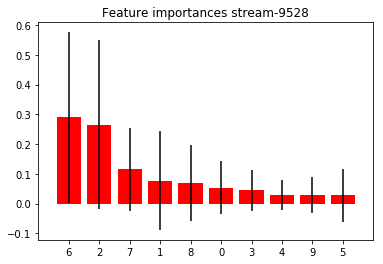

Feature ranking:
1. feature 3 (0.221012)
2. feature 8 (0.180226)
3. feature 2 (0.146057)
4. feature 7 (0.131395)
5. feature 1 (0.088264)
6. feature 6 (0.081207)
7. feature 4 (0.077989)
8. feature 0 (0.029932)
9. feature 5 (0.023474)
10. feature 9 (0.020445)


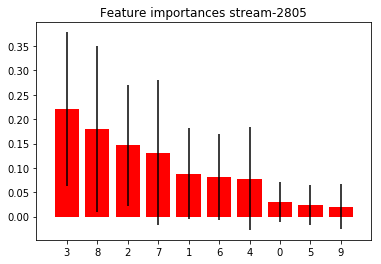

Feature ranking:
1. feature 2 (0.238151)
2. feature 3 (0.201454)
3. feature 6 (0.192636)
4. feature 8 (0.120704)
5. feature 0 (0.078551)
6. feature 7 (0.060872)
7. feature 4 (0.055589)
8. feature 1 (0.030067)
9. feature 5 (0.013624)
10. feature 9 (0.008352)


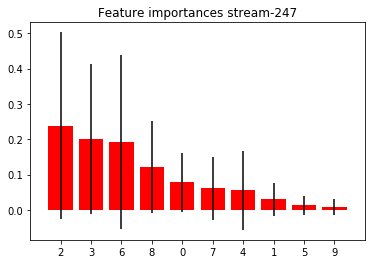

Feature ranking:
1. feature 3 (0.251534)
2. feature 4 (0.151048)
3. feature 7 (0.147275)
4. feature 2 (0.146709)
5. feature 8 (0.113297)
6. feature 6 (0.095016)
7. feature 5 (0.035396)
8. feature 9 (0.030939)
9. feature 0 (0.015858)
10. feature 1 (0.012926)


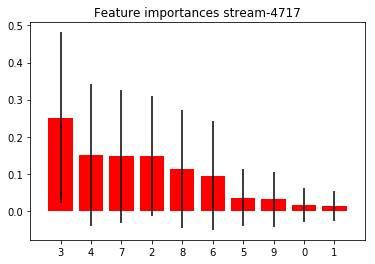

Feature ranking:
1. feature 0 (0.357924)
2. feature 4 (0.225350)
3. feature 3 (0.123582)
4. feature 2 (0.099321)
5. feature 6 (0.085007)
6. feature 8 (0.045243)
7. feature 5 (0.030989)
8. feature 1 (0.024890)
9. feature 7 (0.006064)
10. feature 9 (0.001631)


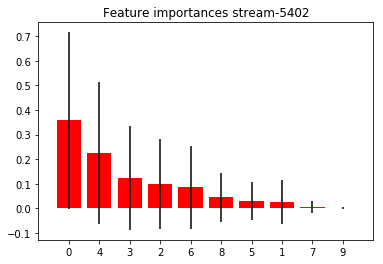

Feature ranking:
1. feature 3 (0.317894)
2. feature 4 (0.252982)
3. feature 6 (0.096237)
4. feature 1 (0.078807)
5. feature 7 (0.074961)
6. feature 2 (0.050645)
7. feature 0 (0.043497)
8. feature 8 (0.034844)
9. feature 9 (0.031828)
10. feature 5 (0.018305)


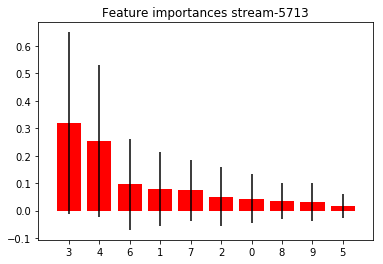

Feature ranking:
1. feature 6 (0.220073)
2. feature 8 (0.216160)
3. feature 2 (0.178350)
4. feature 7 (0.116623)
5. feature 3 (0.107937)
6. feature 1 (0.062922)
7. feature 4 (0.048432)
8. feature 9 (0.028514)
9. feature 5 (0.012328)
10. feature 0 (0.008661)


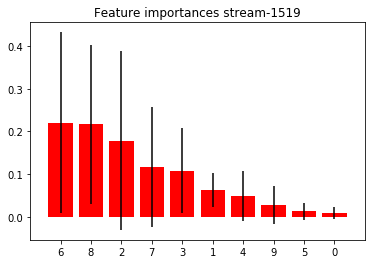

Feature ranking:
1. feature 2 (0.186473)
2. feature 6 (0.168424)
3. feature 7 (0.123127)
4. feature 3 (0.115036)
5. feature 1 (0.102430)
6. feature 4 (0.092068)
7. feature 8 (0.075109)
8. feature 0 (0.064265)
9. feature 5 (0.046766)
10. feature 9 (0.026302)


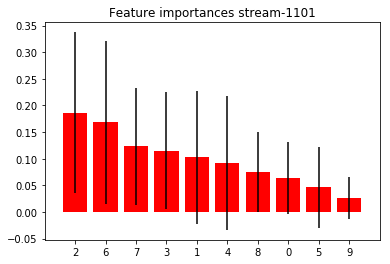

In [51]:
for i in range(8):
    importances = master_forest[i].feature_importances_
    std = np.std([tree.feature_importances_ for tree in master_forest[i].estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")

    for f in range(master_X_train_scaled[i].shape[1]):
        print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

    # Plot the impurity-based feature importances of the forest
    plt.figure()
    plt.title('Feature importances '+viable_new2[i])
    plt.bar(range(master_X_train_scaled[i].shape[1]), importances[indices],
            color="r", yerr=std[indices], align="center")
    plt.xticks(range(master_X_train_scaled[i].shape[1]), indices)
    plt.xlim([-1, master_X_train_scaled[i].shape[1]])
    plt.show()


In [68]:
len(y_test_selflab), len(true_positives), len(false_positives),len(true_negatives), len(false_negatives)

(47293, 8, 8, 8, 8)

In [62]:
iteration_1_adj = []
iteration_final_adj = []
for i in range(10):
    test = iteration_1[i]
    test2 = test.fillna(0)
    iteration_1_adj.append(test2)
    test = iteration_final[i]
    test2 = test.fillna(0)
    iteration_final_adj.append(test2)

IndexError: list index out of range

In [77]:
iteration_1[0]

,stream,true_positives,false_positives,true_negatives,false_negatives,precision,recall,f1,f0.5,f2,bal_acc,matt_coef
0,stream-9528,24,24,10771,47,0.500000,0.338028,0.403361,0.456274,0.361446,0.667902,0.407975
1,stream-2805,124,82,30610,46,0.601942,0.729412,0.659574,0.623742,0.699774,0.863370,0.660579
2,stream-247,157,197,36938,58,0.443503,0.730233,0.551845,0.481300,0.646623,0.862464,0.566013
3,stream-4717,13,16,7858,35,0.448276,0.270833,0.337662,0.396341,0.294118,0.634401,0.345406
4,stream-5402,7,0,5701,26,1.000000,0.212121,0.350000,0.573770,0.251799,0.606061,0.459520
5,stream-5713,37,5,13347,42,0.880952,0.468354,0.611570,0.748988,0.516760,0.733990,0.640937
6,stream-1519,235,1390,48179,69,0.144615,0.773026,0.243650,0.172693,0.413587,0.872492,0.326605
7,stream-1101,215,202,46820,56,0.515588,0.793358,0.625000,0.554409,0.716189,0.894531,0.637093


In [78]:
iteration_final[0]

,stream,true_positives,false_positives,true_negatives,false_negatives,precision,recall,f1,f0.5,f2,bal_acc,matt_coef
0,stream-9528,43,80,10715,28,0.349593,0.605634,0.443299,0.381883,0.528256,0.799111,0.455605
1,stream-2805,133,161,30531,37,0.452381,0.782353,0.573276,0.494056,0.682752,0.888554,0.592122
2,stream-247,166,346,36789,49,0.324219,0.772093,0.456671,0.366770,0.604956,0.881388,0.496278
3,stream-4717,20,48,7826,28,0.294118,0.416667,0.344828,0.312500,0.384615,0.705285,0.345387
4,stream-5402,18,0,5701,15,1.000000,0.545455,0.705882,0.857143,0.600000,0.772727,0.737579
5,stream-5713,44,8,13344,35,0.846154,0.556962,0.671756,0.766551,0.597826,0.778181,0.685064
6,stream-1519,241,1497,48072,63,0.138665,0.792763,0.236043,0.166069,0.407921,0.881281,0.323640
7,stream-1101,239,415,46607,32,0.365443,0.881919,0.516757,0.413924,0.687572,0.936547,0.564329


In [79]:
iteration_1[0].mean()

true_positives       101.500000
false_positives      239.500000
true_negatives     25028.000000
false_negatives       47.375000
precision              0.566859
recall                 0.539421
f1                     0.472833
f0.5                   0.500940
f2                     0.487537
bal_acc                0.766901
matt_coef              0.505516
dtype: float64

In [81]:
iteration_final[0].mean()

true_positives       113.000000
false_positives      319.375000
true_negatives     24948.125000
false_negatives       35.875000
precision              0.471322
recall                 0.669231
f1                     0.493564
f0.5                   0.469862
f2                     0.561737
bal_acc                0.830384
matt_coef              0.525000
dtype: float64

In [62]:
len(y_pred)

47293

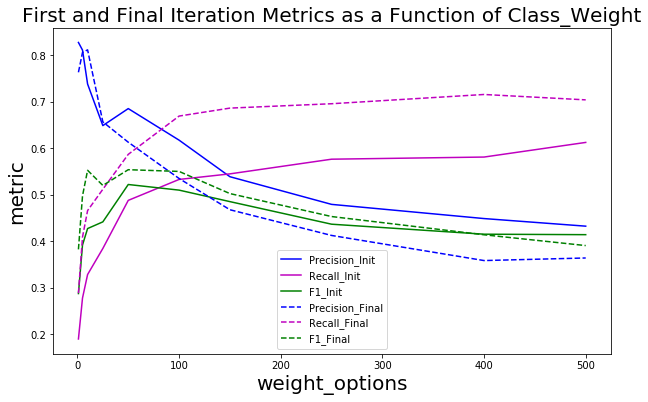

In [46]:
x_vals = weight_1_ops
plt.figure(figsize=(10,6))

#initial iteration
iter_1_prec = [i.precision.mean() for i in iteration_1_adj]
iter_1_rec = [i.recall.mean() for i in iteration_1_adj]
iter_1_f1 = [i.f1.mean() for i in iteration_1_adj]

#final iteration
iter_final_prec = [i.precision.mean() for i in iteration_final_adj]
iter_final_rec = [i.recall.mean() for i in iteration_final_adj]
iter_final_f1 = [i.f1.mean() for i in iteration_final_adj]

plt.plot(x_vals, iter_1_prec, label = 'Precision_Init',color = 'b')
plt.plot(x_vals, iter_1_rec, label = 'Recall_Init',color = 'm')
plt.plot(x_vals, iter_1_f1, label = 'F1_Init',color = 'g')
plt.plot(x_vals, iter_final_prec, label = 'Precision_Final', color = 'b', linestyle='dashed')
plt.plot(x_vals, iter_final_rec, label = 'Recall_Final',color = 'm', linestyle='dashed')
plt.plot(x_vals, iter_final_f1, label = 'F1_Final',color = 'g', linestyle='dashed')
plt.xlabel('weight_options', fontsize=20)
plt.ylabel('metric', fontsize = 20)
plt.title('First and Final Iteration Metrics as a Function of Class_Weight', fontsize = 20)

plt.legend()

In [49]:
plt.figure(figsize=(10,6))
iter_1_prec = [i.precision.mean() for i in iteration_1_adj]
iter_1_rec = [i.recall.mean() for i in iteration_1_adj]
iter_1_f1 = [i.f1.mean() for i in iteration_1_adj]
plt.plot(x_vals, iter_1_prec, label = 'Precision')
plt.plot(x_vals, iter_1_rec, label = 'Recall')
plt.plot(x_vals, iter_1_f1, label = 'F1')
plt.xlabel('weight_options', fontsize=20)
plt.ylabel('metric', fontsize = 20)
plt.title('First Iteration Metrics as a Function of Class_Weight', fontsize = 20)
plt.legend()

,stream,true_positives,false_positives,true_negatives,false_negatives,precision,recall,f1,f1_prec_10,f1_prec_5,f1_rec_5,f1_rec_10
0,stream-9528,3,3,10798,62,0.500000,0.046154,0.084507,0.455639,0.362791,0.047823,0.046572
1,stream-2805,27,1,30673,161,0.964286,0.143617,0.250000,0.912651,0.790541,0.148477,0.144837
2,stream-247,61,6,37111,172,0.910448,0.261803,0.406667,0.888648,0.831237,0.269179,0.263662
3,stream-4717,2,0,7873,47,1.000000,0.040816,0.078431,0.811245,0.525253,0.042380,0.041208
4,stream-5402,14,0,5700,20,1.000000,0.411765,0.583333,0.986053,0.947917,0.421296,0.414177
5,stream-5713,19,2,13355,55,0.904762,0.256757,0.400000,0.882705,0.824708,0.264030,0.258590
6,stream-1519,0,0,49576,297,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,stream-1101,78,8,47025,182,0.906977,0.300000,0.450867,0.889165,0.841494,0.307926,0.302001


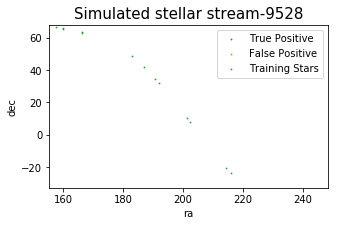

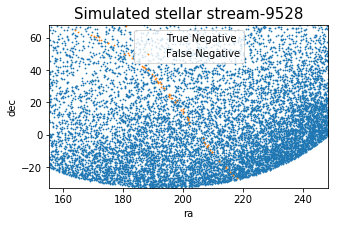

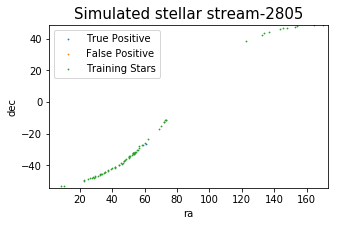

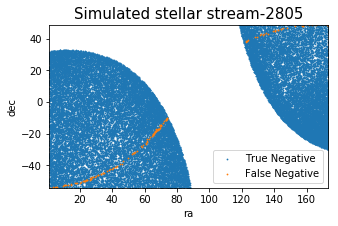

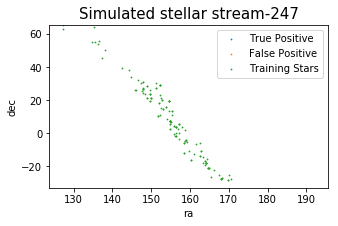

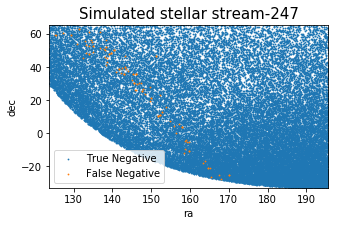

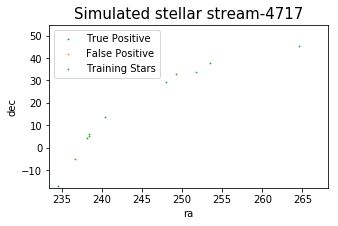

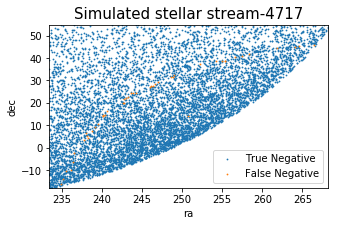

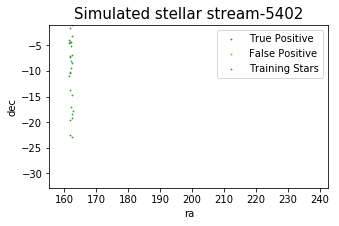

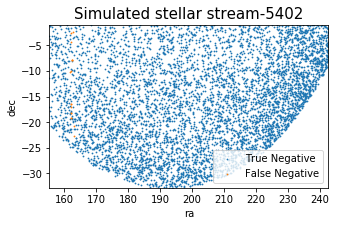

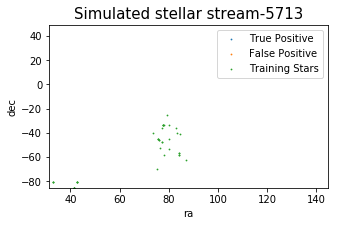

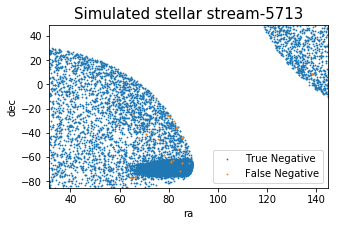

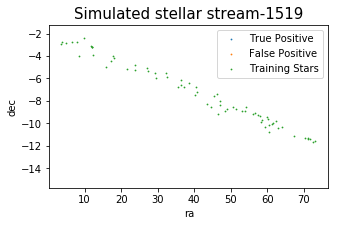

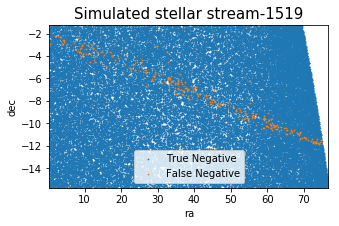

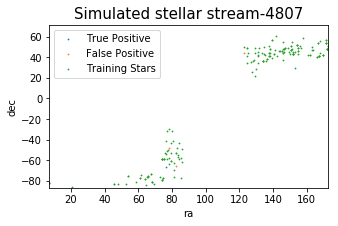

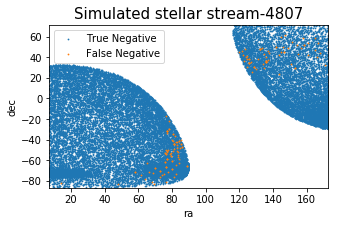

In [178]:
for item in range(len(viable_new2)):
    #Plot performance for Stream in index from 0 to len(streams)
    stream_index = item
    y_test = testing_datas[item].stream_mask
    y_pred = y_preds[item]
    #Truly in Cluster
    X_correct = testing_datas[item][y_test & y_pred] #predicted in cluster (true positives)
    X_incorrect = testing_datas[item][y_test & ~y_pred] #predicted not in cluster (false negative)
    #Truly not in Cluster
    X2_correct = testing_datas[item][~y_test & ~y_pred] #predicted not in cluster (true negative)
    X2_incorrect = testing_datas[item][~y_test & y_pred] #predicted in cluster (false positive)
    
    #Known to model
    known_to_model = training_datas[item]
    known_to_model_stream = known_to_model[known_to_model.stream_mask == True]
    known_to_model_back = known_to_model[known_to_model.stream_mask == False]

    X_correct['label']=1
    X_incorrect['label']=1
    X2_correct['label']=0
    X2_incorrect['label']=0
    
    size_plot = 0.6

    #visualize true and false positives
    plt.figure(figsize = (5,3))
    plt.scatter(X_correct['ra'], X_correct['dec'], label = "True Positive", s = size_plot)
    plt.scatter(X2_incorrect['ra'], X2_incorrect['dec'], label = "False Positive", s=size_plot)
    plt.scatter(known_to_model_stream['ra'], known_to_model_stream['dec'], label = 'Training Stars', s=size_plot)
    plt.xlabel('ra')
    plt.ylabel('dec')
    plt.title('Simulated stellar ' + viable_new[stream_index+9], fontsize = 15)
    plt.xlim(X2_correct['ra'].min(), X2_correct['ra'].max())
    plt.ylim(X2_correct['dec'].min(), X2_correct['dec'].max())
    plt.legend()

    plt.figure(figsize = (5,3))
    plt.scatter(X2_correct['ra'], X2_correct['dec'], label = "True Negative", s=size_plot)
    plt.scatter(X_incorrect['ra'], X_incorrect['dec'], label = "False Negative", s=size_plot)
    #plt.scatter(known_to_model_back['ra'], known_to_model_back['dec'], label = 'Training Stars', s=size_plot)
    plt.xlabel('ra')
    plt.ylabel('dec')
    plt.title('Simulated stellar ' + viable_new[stream_index+9], fontsize = 15)    
    plt.xlim(X2_correct['ra'].min(), X2_correct['ra'].max())
    plt.ylim(X2_correct['dec'].min(), X2_correct['dec'].max())
    plt.legend()
